<a href="https://colab.research.google.com/github/MohammadAghaei1/Plantdoc-image-processing/blob/main/Plantdoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries and  Dataset**

In [1]:
import os
import csv
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
!git clone https://github.com/MohammadAghaei1/Plantdoc-image-processing

Cloning into 'Plantdoc-image-processing'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 179 (delta 79), reused 0 (delta 0), pack-reused 35 (from 1)
Receiving objects: 100% (179/179), 136.78 MiB | 16.92 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [3]:
!unzip /content/Plantdoc-image-processing/Dataset/PlantDoc\ 416x416.zip

Archive:  /content/Plantdoc-image-processing/Dataset/PlantDoc 416x416.zip
 extracting: train/Faske%20Southern%20rust%20of%20corn_jpg.rf.016116db58617610bb259b2965f41589.jpg  
 extracting: train/Slide1_preview_jpg.rf.00f57cfc188631c10e10e2b93a38d296.jpg  
 extracting: train/2017-08-27%2B-%2BLate%2BBlight%2Bon%2BGypsy%2B1_jpg.rf.00584c9d14b6fda3086f9a482675d610.jpg  
 extracting: train/Apple-Scab-image-02_jpg.rf.00cbc9a108dbdaadf4232b5392e3d3c8.jpg  
 extracting: train/24154194959_fd4b42edde_b_jpg.rf.0012f9978a300c5635840700fa784280.jpg  
 extracting: train/2-3%20Gray%20leaf%20spot%20BRUCE_jpg.rf.0040c2e382cf11216938e6f49b7d65ed.jpg  
 extracting: train/Septoria_tomato_Margaret%20B_p8170755_0002_25004_jpg.rf.00ddfef2668a53da256f207f9b844782.jpg  
 extracting: train/d-to-tylv-fo005-14496A31BE70553130A_jpg.rf.017e4558f1b4baeadc32a13beb178a6e.jpg  
 extracting: train/Bacterial-spot-symptoms-on-pepper-leaves-for-web_jpg.rf.01bc16f3b7ba0e4c9fa8c07133a723c6.jpg  
 extracting: train/IMG_6029-00

# **Data Preparation**

## **Defining pathes into variables**

In [4]:
#Train
train_annotation_broken  = '/content/train/_annotations.csv'
train_annotation_clean   = '/content/train/_annotations_clean.csv'
train_images_old = '/content/train'
train_images_new = '/content/train/images'
train_images_separated = '/content/train/images_by_class'
train_splitted_csv = '/content/train/train_annotations.csv'
train_yolo_labels = '/content/train/labels'

#test
test_annotation_broken  = '/content/test/_annotations.csv'
test_annotation_clean   = '/content/test/_annotations_clean.csv'
test_images_old = '/content/test'
test_images_new = '/content/test/images'
test_yolo_labels = '/content/test/labels'

#Validation
val_annotation_clean   = '/content/val/val_annotations.csv'
val_images_old = '/content/val'
val_images_new = '/content/val/images'
val_yolo_labels = '/content/val/labels'

yaml_path = '/content/data.yaml'

## **Defs for Fixing and updating both csv and images**

**Some lines have problem in their names so before reading csv should repair them**

In [5]:
def find_problematic_lines(path):

    problematic_lines = []
    expected_cols = 8
    with open(path, 'r') as f:
        reader = csv.reader(f)
        # Skip the header row
        header = next(reader)
        for i, row in enumerate(reader):
            if len(row) != expected_cols:
                problematic_lines.append((i + 2, row))

    problematic_root = path.replace('_annotations.csv', '')

    if problematic_lines:
        # Save to the test folder
        with open(problematic_root+'problematic_lines.csv', 'w', newline='') as outfile:
            writer = csv.writer(outfile)
            writer.writerow(['Line Number', 'Problematic Row Content'])
            for line_num, row_content in problematic_lines:
                writer.writerow([line_num, ','.join(row_content)])

        print(f"Found {len(problematic_lines)} problematic lines. Details saved to '{problematic_root}problematic_lines.csv'.")
        print(f"Please review '{problematic_root}problematic_lines_train.csv' and fix the data in the original file.")
    else:
        print("No problematic lines found in the annotation file.")

**All the rows was fixed but just 10 of them was the emtpy and they didnt have considrable informations**

In [6]:
def repair_csv(csv_path):

    ANNOTATIONS = Path(csv_path)
    ENCODING    = "utf-8-sig"
    OUT_CLEAN   = ANNOTATIONS.with_name(ANNOTATIONS.stem + "_clean.csv")
    OUT_BAD     = ANNOTATIONS.with_name(ANNOTATIONS.stem + "_unfixable.csv")
    EXPECTED_HEADER = ["filename","width","height","class","xmin","ymin","xmax","ymax"]


    def is_int_token(s: str) -> bool:
        s = s.strip()
        if s.startswith(("+","-")): s = s[1:]
        return s.isdigit()

    def first_consecutive_int_pair(tokens):
        """return index i where tokens[i] and tokens[i+1] are both ints; else None"""
        for i in range(len(tokens) - 1):
            if is_int_token(tokens[i]) and is_int_token(tokens[i+1]):
                return i
        return None

    def rebuild_row(tokens):
        """
        tokens: list obtained by naive comma split via csv.reader
        returns (ok, row_or_reason)
        row format: [filename,width,height,class,xmin,ymin,xmax,ymax]
        """
        toks = [t.strip() for t in tokens if t is not None]

        # 1) locate width,height as the first consecutive int pair
        w_idx = first_consecutive_int_pair(toks)
        if w_idx is None:
            return False, "no consecutive width,height integers found"

        filename = ",".join(toks[:w_idx]).strip().strip('"')
        width, height = toks[w_idx], toks[w_idx + 1]
        rest = toks[w_idx + 2:]

        # Need at least 5 tokens after height (some class + 4 bbox ints)
        if len(rest) < 5:
            return False, "not enough fields after height"

        # 2) pick the LAST 4 integer tokens in 'rest' -> bbox
        bbox_indices = []
        for j in range(len(rest) - 1, -1, -1):
            if is_int_token(rest[j]):
                bbox_indices.append(j)
                if len(bbox_indices) == 4:
                    break
        if len(bbox_indices) != 4:
            return False, "could not find 4 bbox integers in tail"
        bbox_indices.sort()
        xmin, ymin, xmax, ymax = [rest[k] for k in bbox_indices]

        # 3) class = everything between height and earliest bbox int
        class_tokens = rest[:bbox_indices[0]]
        if not class_tokens:
            return False, "class field missing"
        class_name = ",".join(class_tokens).strip().strip('"')

        return True, [filename, width, height, class_name, xmin, ymin, xmax, ymax]

    def main():
        fixed, bad = [], []

        with ANNOTATIONS.open(encoding=ENCODING, newline="") as f:
            rdr = csv.reader(f)
            _ = next(rdr, None)  # skip original header if present
            for row in rdr:
                ok, out = rebuild_row(row)
                if ok:
                    fixed.append(out)
                else:
                    bad.append({"reason": out, "raw": ",".join(row)})

        # Write clean file
        with OUT_CLEAN.open("w", newline="", encoding=ENCODING) as f:
            w = csv.writer(f)
            w.writerow(EXPECTED_HEADER)
            w.writerows(fixed)

        # Write any unfixable rows for manual check
        with OUT_BAD.open("w", newline="", encoding=ENCODING) as f:
            w = csv.writer(f)
            w.writerow(["reason","raw_line"])
            for br in bad:
                w.writerow([br["reason"], br["raw"]])

        print(f" Clean rows written: {len(fixed)} -> {OUT_CLEAN}")
        print(f" Unfixable empty rows: {len(bad)} -> {OUT_BAD}")

    if __name__ == "__main__":
        main()


**Put all images in train fodler to train/images**

In [7]:
def move_images_to_correct_folder(source_dir, destination_dir):

    import os
    import shutil

    source_dir = source_dir
    destination_dir = destination_dir

    # Create the destination directory if it doesn't exist
    os.makedirs(destination_dir, exist_ok=True)

    # List all files in the source directory
    all_files = os.listdir(source_dir)

    moved_count = 0
    for filename in all_files:
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_dir, filename)

        # Check if the file is a file (not a directory) and if it has a .jpg extension
        if os.path.isfile(source_path) and filename.lower().endswith('.jpg'):
            try:
                shutil.move(source_path, destination_path)
                moved_count += 1
            except Exception as e:
                print(f"Error moving {filename}: {e}")

    print(f"Moved {moved_count} image files from {source_dir} to {destination_dir}")

**Check all unique names in annotation file to be in train folder**

In [8]:
def check_unique_annotation_image(annotation_path, images_path ):

    import os
    import pandas as pd
    from pathlib import Path

    # Load the cleaned training annotations CSV file
    cleaned_annotations_path = annotation_path
    cleaned_annotation_df = pd.read_csv(cleaned_annotations_path)

    # Get the set of unique filenames from the CSV
    csv_filenames = set(cleaned_annotation_df['filename'].unique())

    # Get the set of image filenames from the directory
    train_images_dir = images_path
    # List files in the directory and get their base names
    image_files = set([f for f in os.listdir(train_images_dir) if os.path.isfile(os.path.join(train_images_dir, f))])


    # Find the filenames that are in the CSV but not in the image directory
    missing_images_in_directory = list(csv_filenames - image_files)

    if missing_images_in_directory:
        print(f"Found {len(missing_images_in_directory)} filenames in '{cleaned_annotations_path}' that are NOT in '{train_images_dir}':")
        for filename in missing_images_in_directory:
            print(filename)
    else:
        print("All unique filenames in the CSV have corresponding image files in the directory.")

**Check all the images in train folder to be in csv file then delete them**

In [9]:
def check_unique_image_annotation(annotation_path, images_path ):

    import os
    import pandas as pd

    # Load the cleaned training annotations CSV file
    cleaned_annotations_path = annotation_path
    cleaned_annotation_df = pd.read_csv(cleaned_annotations_path)

    # Get the set of unique filenames from the CSV
    csv_filenames = set(cleaned_annotation_df['filename'].unique())

    # Get the set of image filenames from the directory
    train_images_dir = images_path
    image_files = set([f for f in os.listdir(train_images_dir) if os.path.isfile(os.path.join(train_images_dir, f))])

    # Find the filenames that are in the image directory but not in the CSV
    images_only_in_directory = list(image_files - csv_filenames)

    # Calculate the number of matches
    matching_files_count = len(image_files) - len(images_only_in_directory)

    print(f"Number of matching image files in '{train_images_dir}' and unique filenames in '{cleaned_annotations_path}': {matching_files_count}")


    if images_only_in_directory:
        print(f"\nFound {len(images_only_in_directory)} image files in '{train_images_dir}' that are NOT in '{cleaned_annotations_path}':")

        deleted_count = 0
        for filename in images_only_in_directory:
            image_path = os.path.join(train_images_dir, filename)
            #print(f"\nAttempting to delete {len(images_only_in_directory)} image files from {train_images_dir}")

            if os.path.exists(image_path):
                try:
                    os.remove(image_path)
                    deleted_count += 1
                    print(f"\nDeleted: {filename}")
                except Exception as e:
                    print(f"Error deleting {filename}: {e}")
            else:
                print(f"File not found, skipping: {filename}")

            print(f"Finished deleting images. Successfully deleted {deleted_count} files.")
    else:
        print("All image files in the directory have corresponding unique filenames in the CSV.")

    print(f"\nNumber of matching image files and unique filenames in CSV file are : {matching_files_count}")

**Checking duplicate items in both train image folder and also csv annotation file**

In [10]:
def check_duplicate_images_rows(imgaes_path, csv_path):

    import os
    import hashlib

    def hash_file(filepath):
        """Calculates the SHA256 hash of a file."""
        hasher = hashlib.sha256()
        with open(filepath, 'rb') as f:
            while True:
                chunk = f.read(4096)
                if not chunk:
                    break
                hasher.update(chunk)
        return hasher.hexdigest()

    train_images_dir = imgaes_path
    image_files = [os.path.join(train_images_dir, f) for f in os.listdir(train_images_dir) if os.path.isfile(os.path.join(train_images_dir, f))]

    hashes = {}
    duplicates = []

    print(f"Checking for duplicate images in {train_images_dir}...")

    for filepath in image_files:
        try:
            file_hash = hash_file(filepath)
            if file_hash in hashes:
                duplicates.append((filepath, hashes[file_hash]))
            else:
                hashes[file_hash] = filepath
        except Exception as e:
            print(f"Error processing file {filepath}: {e}")

    if duplicates:
        print("Found duplicate images:")
        for file1, file2 in duplicates:
            print(f"- {file1} is a duplicate of {file2}")
    else:
        print("No duplicate images found.")

    read_csv = pd.read_csv(csv_path)
    duplicate_rows = annotation.duplicated().sum()
    print(f"\nChecking for duplicate rows in {train_images_dir}...")
    print(f"Number of duplicate rows: {duplicate_rows}")

**Checking problematic bounding boxes in csv train file**

In [11]:
def check_problematic_bbox(csv_path):


    import pandas as pd
    from pathlib import Path
    from urllib.parse import unquote

    # --- paths ---
    CSV = csv_path   # your CSV
    OUT = Path(CSV.replace('_annotations_clean.csv', '')); OUT.mkdir(parents=True, exist_ok=True)

    # --- read & normalize columns ---
    df = pd.read_csv(CSV)
    df.columns = [c.strip().lower() for c in df.columns]
    required = {"filename","width","height","class","xmin","ymin","xmax","ymax"}
    missing  = required - set(df.columns)
    assert not missing, f"Missing columns: {missing}"

    # filename → basename only
    df["__file"] = df["filename"].map(lambda x: Path(unquote(str(x))).name)

    # numeric conversion
    for c in ["width","height","xmin","ymin","xmax","ymax"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # --- checks ---
    EPS = 1e-6
    MIN_AREA_PCT = 1e-4  # 0.01% of image

    W, H = df["width"], df["height"]
    wpx  = df["xmax"] - df["xmin"]
    hpx  = df["ymax"] - df["ymin"]
    area = wpx * hpx

    df["_bad_wh"]     = (W<=0) | (H<=0) | W.isna() | H.isna()
    df["_oob"]        = (df["xmin"]<-EPS) | (df["ymin"]<-EPS) | (df["xmax"]>W+EPS) | (df["ymax"]>H+EPS)
    df["_zero_neg"]   = (wpx<=EPS) | (hpx<=EPS)
    df["_very_small"] = (area / (W*H + EPS)) < MIN_AREA_PCT
    df["_non_numeric"]= df[["xmin","ymin","xmax","ymax","width","height"]].isna().any(axis=1)

    # rows with any issue
    mask = df[["_bad_wh","_oob","_zero_neg","_very_small","_non_numeric"]].any(axis=1)
    bad  = df.loc[mask, ["__file","class","width","height","xmin","ymin","xmax","ymax",
                        "_oob","_zero_neg","_very_small","_non_numeric"]]

    # --- reports ---
    bad_path   = OUT/"csv_bbox_qc.csv"
    perimg_path= OUT/"csv_bbox_qc_per_image.csv"

    bad.to_csv(bad_path, index=False)

    # per-image summary (which issues appear in each image)
    if len(bad):
        per_img = (bad.groupby("__file")[["_oob","_zero_neg","_very_small","_non_numeric"]]
                  .max().reset_index())
        per_img["issues_in_image"] = per_img[["_oob","_zero_neg","_very_small","_non_numeric"]].sum(axis=1)
        per_img.sort_values("issues_in_image", ascending=False).to_csv(perimg_path, index=False)

    # --- pretty summary ---
    rows     = len(df)
    images   = df["__file"].nunique()
    bad_rows = len(bad)
    ok_rows  = rows - bad_rows

    def pct(n, d):
        return f"{n} ({0 if d==0 else 100*n/d:.2f}%)"

    issue_counts = {
        "out_of_bounds": int(df["_oob"].sum()),
        "zero_or_negative": int(df["_zero_neg"].sum()),
        "very_small": int(df["_very_small"].sum()),
        "non_numeric": int(df["_non_numeric"].sum()),
        "bad_width_height": int(df["_bad_wh"].sum()),
    }

    print("\n" + "="*62)
    print("CSV BBox QC — Summary")
    print("="*62)
    print(f"Rows (boxes): {rows}")
    print(f"Images:       {images}")
    print(f"OK rows:      {pct(ok_rows, rows)}")
    print(f"Bad rows:     {pct(bad_rows, rows)}")
    print("-"*62)
    for k,v in issue_counts.items():
        print(f"{k:>18}: {pct(v, rows)}")
    print("-"*62)
    print(f"Report (rows) -> {bad_path}")
    if bad_rows:
        print(f"Report (per-image) -> {perimg_path}")
        print("\nTop 10 problematic rows:")
        print(bad.head(10).to_string(index=False))
    else:
        print("No problematic rows found ")


**Checking the bounding boxes sizes that are usefull in preprocessing fot train folder**

In [12]:
def check_bbox_size(csv_path):

    import pandas as pd
    from pathlib import Path
    from urllib.parse import unquote
    import math

    # ---- inputs ----
    CSV = csv_path
    OUT = Path(CSV.replace('_annotations_clean.csv', '')); OUT.mkdir(parents=True, exist_ok=True)
    IMG_SIZE = 416  # only used to show an approximate square side in pixels

    # ---- load ----
    df = pd.read_csv(CSV)
    df.columns = [c.strip().lower() for c in df.columns]
    for c in ["width","height","xmin","ymin","xmax","ymax"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    valid = df.dropna(subset=["width","height","xmin","ymin","xmax","ymax"]).copy()
    valid = valid[(valid["width"]>0) & (valid["height"]>0)]
    area  = ((valid["xmax"]-valid["xmin"]) * (valid["ymax"]-valid["ymin"])) / (valid["width"]*valid["height"])

    # ---- thresholds ----
    TINY, SMALL, MEDIUM = 0.0025, 0.01, 0.10  # 0.25%, 1%, 10%

    bins = {
        "tiny":   (area < TINY),
        "small":  (area >= TINY) & (area < SMALL),
        "medium": (area >= SMALL) & (area < MEDIUM),
        "large":  (area >= MEDIUM),
    }
    total = int(area.shape[0])
    pct = lambda n: (0 if total==0 else 100*n/total)

    def side_px(frac): return int(math.sqrt(max(frac,0))*IMG_SIZE)

    rows = []
    for name, mask in bins.items():
        cnt = int(mask.sum())
        rng = {"tiny":f"[0,{TINY:.4f})","small":f"[{TINY:.4f},{SMALL:.4f})",
              "medium":f"[{SMALL:.4f},{MEDIUM:.4f})","large":f"[{MEDIUM:.4f},1.0000]"}[name]
        if name=="tiny":   side="≤"+str(side_px(TINY))+"px"
        elif name=="small":side=f"{side_px(TINY)}–{side_px(SMALL)}px"
        elif name=="medium":side=f"{side_px(SMALL)}–{side_px(MEDIUM)}px"
        else:              side="≥"+str(side_px(MEDIUM))+"px"
        rows.append({"bucket":name, "range":rng, "count":cnt, "percent":f"{pct(cnt):.1f}%", "≈square_side@416":side})

    dist_df = pd.DataFrame(rows, columns=["bucket","range","count","percent","≈square_side@416"])
    dist_df.to_csv(OUT/"size_distribution.csv", index=False)

    # ---- single concise print ----
    print("BBox size distribution (normalized area) — total instances:", total)
    print(dist_df.to_string(index=False))
    print("Saved:", OUT/"size_distribution.csv")


**Cleaning images name in both CSV file sake of preprocessing step**

In [13]:
def clean_image_csv_names(image_path, csv_path):

    import os
    import pandas as pd
    import re

    # Function to sanitize names (keeping the file extension intact)
    def sanitize_name(name: str) -> str:
        # Split name and extension
        base_name, ext = os.path.splitext(name)

        # Sanitize the base name (excluding the extension)
        base_name = base_name.strip()
        base_name = base_name.replace("%20", "_")  # Replace '%20' (spaces) with underscore
        base_name = base_name.replace("%", "pct")  # Replace '%' with 'pct'
        base_name = base_name.replace("#", "num")  # Replace '#' with 'num'
        base_name = base_name.replace("&", "and")  # Replace '&' with 'and'
        base_name = re.sub(r"[\s\-]+", "_", base_name.lower())  # Replace spaces and dashes with '_'
        base_name = re.sub(r"[^\w]", "", base_name)  # Remove non-alphanumeric characters
        base_name = re.sub(r"_+", "_", base_name)  # Collapse multiple underscores
        base_name = base_name.strip("_")  # Strip leading/trailing underscores

        # Combine the sanitized base name with the original extension
        return base_name + ext

    # Load the CSV
    csv_path = csv_path  # Replace with your CSV file path
    df = pd.read_csv(csv_path)

    # Path to your images folder
    images_path = image_path  # Replace with your images folder path

    # Loop through each row in the CSV
    for index, row in df.iterrows():
        image_name = row['filename']

        if not image_name:  # Skip rows where the filename is empty
            continue

        # Check if the image exists in the images folder
        image_files = os.listdir(images_path)
        matched_image = None

        for image in image_files:
            if image_name.lower() in image.lower():  # Match based on partial filename (case-insensitive)
                matched_image = image
                break

        if matched_image:  # If a matching image is found
            sanitized_image_name = sanitize_name(matched_image)

            # If the image name needs fixing
            if sanitized_image_name != matched_image:
                original_image_path = os.path.join(images_path, matched_image)
                sanitized_image_path = os.path.join(images_path, sanitized_image_name)

                # Rename the image in the images folder
                os.rename(original_image_path, sanitized_image_path)

                # Update all occurrences of the image filename in the CSV
                df['filename'] = df['filename'].replace(matched_image, sanitized_image_name)

    # Save the updated CSV with new filenames
    csv_rooot = csv_path.replace('_annotations_clean.csv', '')
    updated_csv_path = csv_rooot+"_annotations_clean.csv"  # Replace with desired output CSV path
    df.to_csv(updated_csv_path, index=False)

    print("Image names and CSV file have been updated for all annotations.")


## **Train Data (Checking and fixing)**

In [14]:
find_problematic_lines(train_annotation_broken)

Found 34 problematic lines. Details saved to '/content/train/problematic_lines.csv'.
Please review '/content/train/problematic_lines_train.csv' and fix the data in the original file.


In [15]:
repair_csv(train_annotation_broken)

 Clean rows written: 8353 -> /content/train/_annotations_clean.csv
 Unfixable empty rows: 10 -> /content/train/_annotations_unfixable.csv


In [16]:
annotation = pd.read_csv(train_annotation_clean)
annotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  8353 non-null   object
 1   width     8353 non-null   int64 
 2   height    8353 non-null   int64 
 3   class     8353 non-null   object
 4   xmin      8353 non-null   int64 
 5   ymin      8353 non-null   int64 
 6   xmax      8353 non-null   int64 
 7   ymax      8353 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 522.2+ KB


In [17]:
check_duplicate_images_rows(train_images_old, train_annotation_clean)

Checking for duplicate images in /content/train...
No duplicate images found.

Checking for duplicate rows in /content/train...
Number of duplicate rows: 0


In [18]:
move_images_to_correct_folder(train_images_old, train_images_new)

Moved 2328 image files from /content/train to /content/train/images


In [19]:
check_unique_annotation_image(train_annotation_clean, train_images_new )

All unique filenames in the CSV have corresponding image files in the directory.


In [20]:
check_unique_image_annotation(train_annotation_clean, train_images_new )

Number of matching image files in '/content/train/images' and unique filenames in '/content/train/_annotations_clean.csv': 2318

Found 10 image files in '/content/train/images' that are NOT in '/content/train/_annotations_clean.csv':

Deleted: tomato_D4a-TobRingspotVirus-1000077_zoom_jpg.rf.2e3bf56fca79319caad79756a5a3489f.jpg
Finished deleting images. Successfully deleted 1 files.

Deleted: 270412tglr-wild-strawberry-flowers-and-leaf-patch_jpg.rf.11e3d6fa8e0828ac716e6e40f92ebd6b.jpg
Finished deleting images. Successfully deleted 2 files.

Deleted: pm1_600px_jpg.rf.cd599fa610030885978e3f8741b8eba8.jpg
Finished deleting images. Successfully deleted 3 files.

Deleted: aquilegia-powdery-mildew-erysiphe-aquilegiae-on-columbine-leaves-bga5xr_jpg.rf.bd049474ad6eb0ee96506e9b2a2771ac.jpg
Finished deleting images. Successfully deleted 4 files.

Deleted: raspberries_jpg.rf.6f265fc0cc6e20357544cda8c1e08794.jpg
Finished deleting images. Successfully deleted 5 files.

Deleted: Black+Raspberry+Leave

In [21]:
check_problematic_bbox(train_annotation_clean)


CSV BBox QC — Summary
Rows (boxes): 8353
Images:       2318
OK rows:      8353 (100.00%)
Bad rows:     0 (0.00%)
--------------------------------------------------------------
     out_of_bounds: 0 (0.00%)
  zero_or_negative: 0 (0.00%)
        very_small: 0 (0.00%)
       non_numeric: 0 (0.00%)
  bad_width_height: 0 (0.00%)
--------------------------------------------------------------
Report (rows) -> /content/train/csv_bbox_qc.csv
No problematic rows found 


In [22]:
check_bbox_size(train_annotation_clean)

BBox size distribution (normalized area) — total instances: 8353
bucket           range  count percent ≈square_side@416
  tiny      [0,0.0025)     66    0.8%            ≤20px
 small [0.0025,0.0100)    555    6.6%          20–41px
medium [0.0100,0.1000)   4701   56.3%         41–131px
 large [0.1000,1.0000]   3031   36.3%           ≥131px
Saved: /content/train/size_distribution.csv


In [23]:
clean_image_csv_names(train_images_new, train_annotation_clean)

Image names and CSV file have been updated for all annotations.


## **Test Data (Checking and fixing)**

In [24]:
find_problematic_lines(test_annotation_broken)

Found 2 problematic lines. Details saved to '/content/test/problematic_lines.csv'.
Please review '/content/test/problematic_lines_train.csv' and fix the data in the original file.


In [25]:
repair_csv(test_annotation_broken)

 Clean rows written: 454 -> /content/test/_annotations_clean.csv
 Unfixable empty rows: 1 -> /content/test/_annotations_unfixable.csv


In [26]:
annotation_test = pd.read_csv(test_annotation_clean)
annotation_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  454 non-null    object
 1   width     454 non-null    int64 
 2   height    454 non-null    int64 
 3   class     454 non-null    object
 4   xmin      454 non-null    int64 
 5   ymin      454 non-null    int64 
 6   xmax      454 non-null    int64 
 7   ymax      454 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 28.5+ KB


In [27]:
check_duplicate_images_rows(test_images_old, test_annotation_clean)

Checking for duplicate images in /content/test...
No duplicate images found.

Checking for duplicate rows in /content/test...
Number of duplicate rows: 0


In [28]:
move_images_to_correct_folder(test_images_old, test_images_new)

Moved 239 image files from /content/test to /content/test/images


In [29]:
check_unique_annotation_image(test_annotation_clean, test_images_new )

All unique filenames in the CSV have corresponding image files in the directory.


In [30]:
check_unique_image_annotation(test_annotation_clean, test_images_new )

Number of matching image files in '/content/test/images' and unique filenames in '/content/test/_annotations_clean.csv': 238

Found 1 image files in '/content/test/images' that are NOT in '/content/test/_annotations_clean.csv':

Deleted: squashsilver2_JPG_jpg.rf.02bdb1c8a5c8bdf6f689f2fda33af990.jpg
Finished deleting images. Successfully deleted 1 files.

Number of matching image files and unique filenames in CSV file are : 238


In [31]:
check_problematic_bbox(test_annotation_clean)


CSV BBox QC — Summary
Rows (boxes): 454
Images:       238
OK rows:      454 (100.00%)
Bad rows:     0 (0.00%)
--------------------------------------------------------------
     out_of_bounds: 0 (0.00%)
  zero_or_negative: 0 (0.00%)
        very_small: 0 (0.00%)
       non_numeric: 0 (0.00%)
  bad_width_height: 0 (0.00%)
--------------------------------------------------------------
Report (rows) -> /content/test/csv_bbox_qc.csv
No problematic rows found 


In [32]:
check_bbox_size(test_annotation_clean)

BBox size distribution (normalized area) — total instances: 454
bucket           range  count percent ≈square_side@416
  tiny      [0,0.0025)      0    0.0%            ≤20px
 small [0.0025,0.0100)      3    0.7%          20–41px
medium [0.0100,0.1000)    139   30.6%         41–131px
 large [0.1000,1.0000]    312   68.7%           ≥131px
Saved: /content/test/size_distribution.csv


In [33]:
clean_image_csv_names(test_images_new, test_annotation_clean)

Image names and CSV file have been updated for all annotations.


## **Adjusting Training and Testing set**

In [34]:
train_annotation_df = pd.read_csv(train_annotation_clean)

/tmp/ipython-input-818736985.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.index, y=counts.values, palette='viridis')


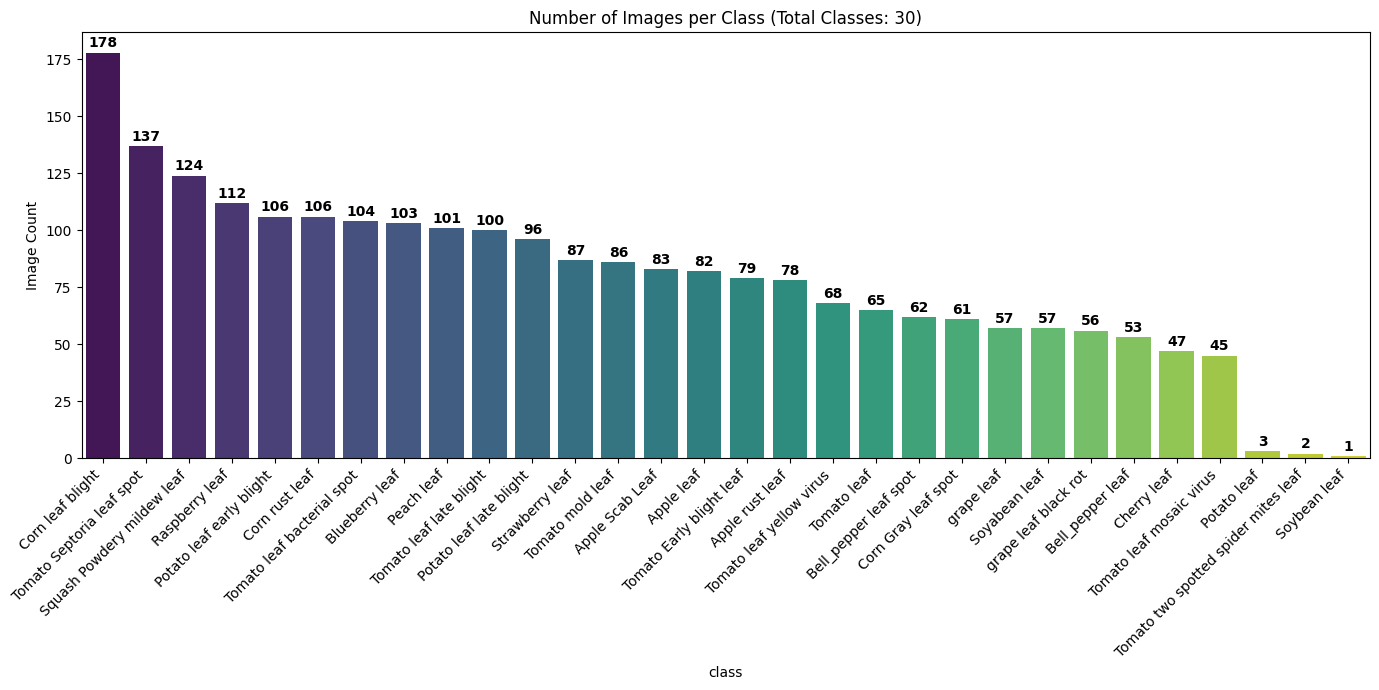

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate unique images per class
counts = train_annotation_df.groupby('class')['filename'].nunique().sort_values(ascending=False)

# 2. Get total number of unique classes
num_classes = train_annotation_df['class'].nunique()

# 3. Plot
plt.figure(figsize=(14, 7))
ax = sns.barplot(x=counts.index, y=counts.values, palette='viridis')

# 4. Add numbers on top of bars
for i, v in enumerate(counts.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontweight='bold')

# 5. Add the total class count to the title
plt.title(f"Number of Images per Class (Total Classes: {num_classes})")

# Rotate labels to 45 degrees
plt.xticks(rotation=45, ha='right')

plt.ylabel("Image Count")
plt.tight_layout()
plt.show()

In [36]:
test_annotation_df = pd.read_csv(test_annotation_clean)

/tmp/ipython-input-3402751996.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.index, y=counts.values, palette='viridis')


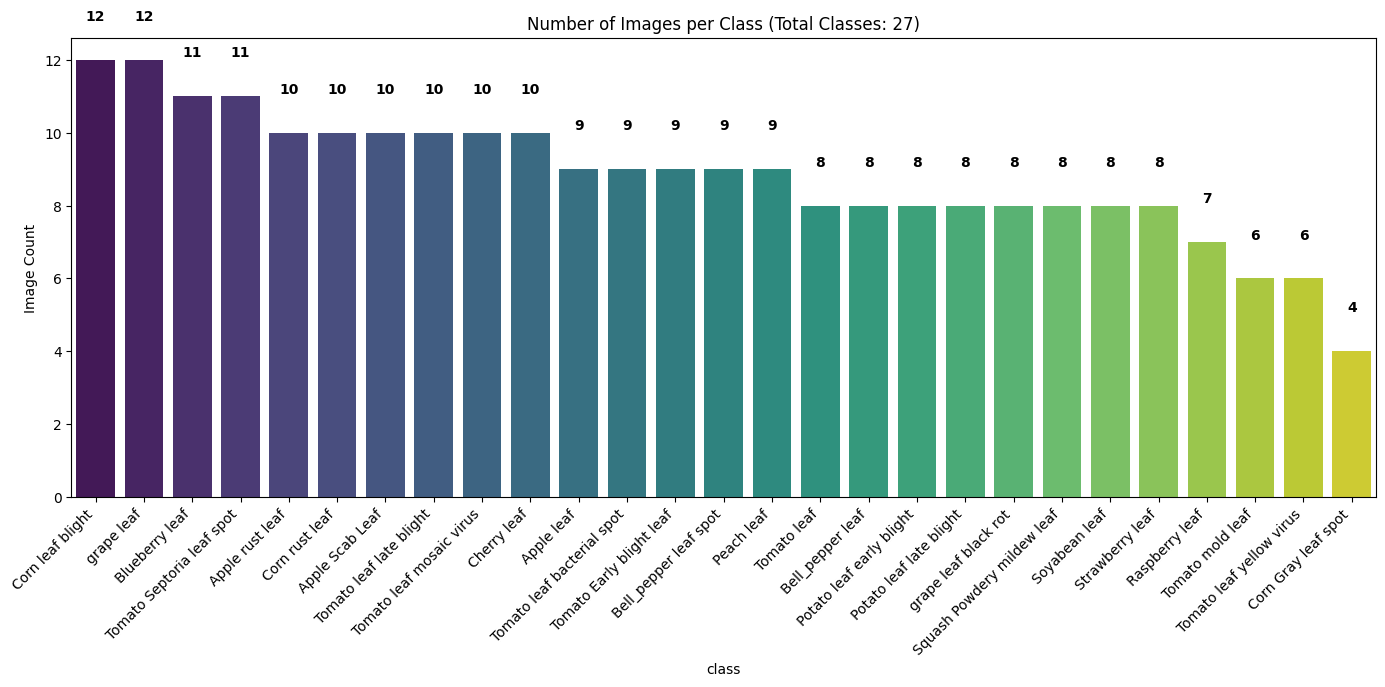

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate unique images per class
counts = test_annotation_df.groupby('class')['filename'].nunique().sort_values(ascending=False)

# 2. Get total number of unique classes
num_classes = test_annotation_df['class'].nunique()

# 3. Plot
plt.figure(figsize=(14, 7))
ax = sns.barplot(x=counts.index, y=counts.values, palette='viridis')

# 4. Add numbers on top of bars
for i, v in enumerate(counts.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontweight='bold')

# 5. Add the total class count to the title
plt.title(f"Number of Images per Class (Total Classes: {num_classes})")

# Rotate labels to 45 degrees
plt.xticks(rotation=45, ha='right')

plt.ylabel("Image Count")
plt.tight_layout()
plt.show()

**Checking the classes names that should be same in test and train data**

In [38]:
import pandas as pd

# Load the train and test annotation files
train_annotation_path = train_annotation_clean
test_annotation_path = test_annotation_clean

try:
    train_df = pd.read_csv(train_annotation_path)
    test_df = pd.read_csv(test_annotation_path)

    # Get the set of unique class names from each DataFrame
    train_classes = set(train_df['class'].unique())
    test_classes = set(test_df['class'].unique())

    # Compare the sets of class names
    if train_classes == test_classes:
        print("The unique class names in the train and test annotation files are the same.")
    else:
        print("The unique class names in the train and test annotation files are NOT the same.")
        # Optionally, print the differences
        if train_classes - test_classes:
            print(f"Classes found in train but not in test: {train_classes - test_classes}")
        if test_classes - train_classes:
            print(f"Classes found in test but not in train: {test_classes - train_classes}")

except FileNotFoundError as e:
    print(f"Error: One of the annotation files was not found. {e}")
except KeyError:
    print("Error: 'class' column not found in one of the CSV files.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

The unique class names in the train and test annotation files are NOT the same.
Classes found in train but not in test: {'Potato leaf', 'Tomato two spotted spider mites leaf', 'Soybean leaf'}


**There is misspling in soybean name soyabean -> soybean**

In [39]:

train_annotation_df['class'] = train_annotation_df['class'].replace('Soybean leaf', 'Soyabean leaf')
print("Changed 'Soybean leaf' to 'Soyabean leaf'")

Changed 'Soybean leaf' to 'Soyabean leaf'


**Changing this photo label to Tomato Early blight leaf**

In [40]:
cell_name = "SpotSpeckBlightMite-1l4v879_jpg.rf.e5e1f97a7071fa00e99d282befc837d3.jpg"
train_annotation_df.loc[
    (train_annotation_df["filename"] == cell_name) &
    (train_annotation_df["class"] == "Tomato two spotted spider mites leaf"),
    "class"
] = "Tomato Early blight leaf"

print(f"Updated class for filename: {cell_name}")

Updated class for filename: SpotSpeckBlightMite-1l4v879_jpg.rf.e5e1f97a7071fa00e99d282befc837d3.jpg


**Deleting two redundent classes due to very small number of images inside of them**

In [41]:
train_annotation_df = train_annotation_df[~train_annotation_df['class'].isin(['Tomato two spotted spider mites leaf', 'Potato leaf'])]

In [42]:
train_annotation_df.to_csv(train_annotation_clean, index=False)
print("Filtered annotations saved to /content/train/_annotations_clean.csv")

Filtered annotations saved to /content/train/_annotations_clean.csv


## **Making separated foldrs based on Training set**

**Making separate the images on training folder base on their classes**

In [43]:
import os
import pandas as pd

# Load the cleaned and filtered training annotations CSV file
cleaned_annotations_path = train_annotation_clean
annotation_df = pd.read_csv(cleaned_annotations_path)

# Get unique class names
unique_classes = annotation_df['class'].unique()

# Define the base output directory within train/images
output_base_dir = train_images_separated

# Create the base output directory if it doesn't exist
os.makedirs(output_base_dir, exist_ok=True)

# Create a subdirectory for each unique class
for class_name in unique_classes:
    class_dir = os.path.join(output_base_dir, class_name.replace(" ", "_")) # Replace spaces with underscores for directory names
    os.makedirs(class_dir, exist_ok=True)
    print(f"Created directory: {class_dir}")

print("\nFinished creating class directories within train/images.")

Created directory: /content/train/images_by_class/Corn_rust_leaf
Created directory: /content/train/images_by_class/Corn_leaf_blight
Created directory: /content/train/images_by_class/Tomato_leaf_late_blight
Created directory: /content/train/images_by_class/Apple_Scab_Leaf
Created directory: /content/train/images_by_class/Tomato_Septoria_leaf_spot
Created directory: /content/train/images_by_class/Tomato_mold_leaf
Created directory: /content/train/images_by_class/Bell_pepper_leaf_spot
Created directory: /content/train/images_by_class/Potato_leaf_early_blight
Created directory: /content/train/images_by_class/grape_leaf_black_rot
Created directory: /content/train/images_by_class/Tomato_leaf_yellow_virus
Created directory: /content/train/images_by_class/Blueberry_leaf
Created directory: /content/train/images_by_class/Bell_pepper_leaf
Created directory: /content/train/images_by_class/Apple_rust_leaf
Created directory: /content/train/images_by_class/Tomato_leaf_bacterial_spot
Created directory

**Moving images in their folders base on their class names**

In [44]:
import os
import shutil
import pandas as pd
from urllib.parse import unquote

# Load Data
df = pd.read_csv(train_annotation_clean)

# Copy loop
for _, row in df.iterrows():
    filename = unquote(row['filename'])
    dest_dir = os.path.join(train_images_separated, row['class'].replace(" ", "_"))

    # Create folder and copy
    os.makedirs(dest_dir, exist_ok=True)
    shutil.copy(os.path.join(train_images_new, filename), dest_dir)

print("Finished copying images to class directories.")

Finished copying images to class directories.


# **EDA**

/tmp/ipython-input-818736985.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.index, y=counts.values, palette='viridis')


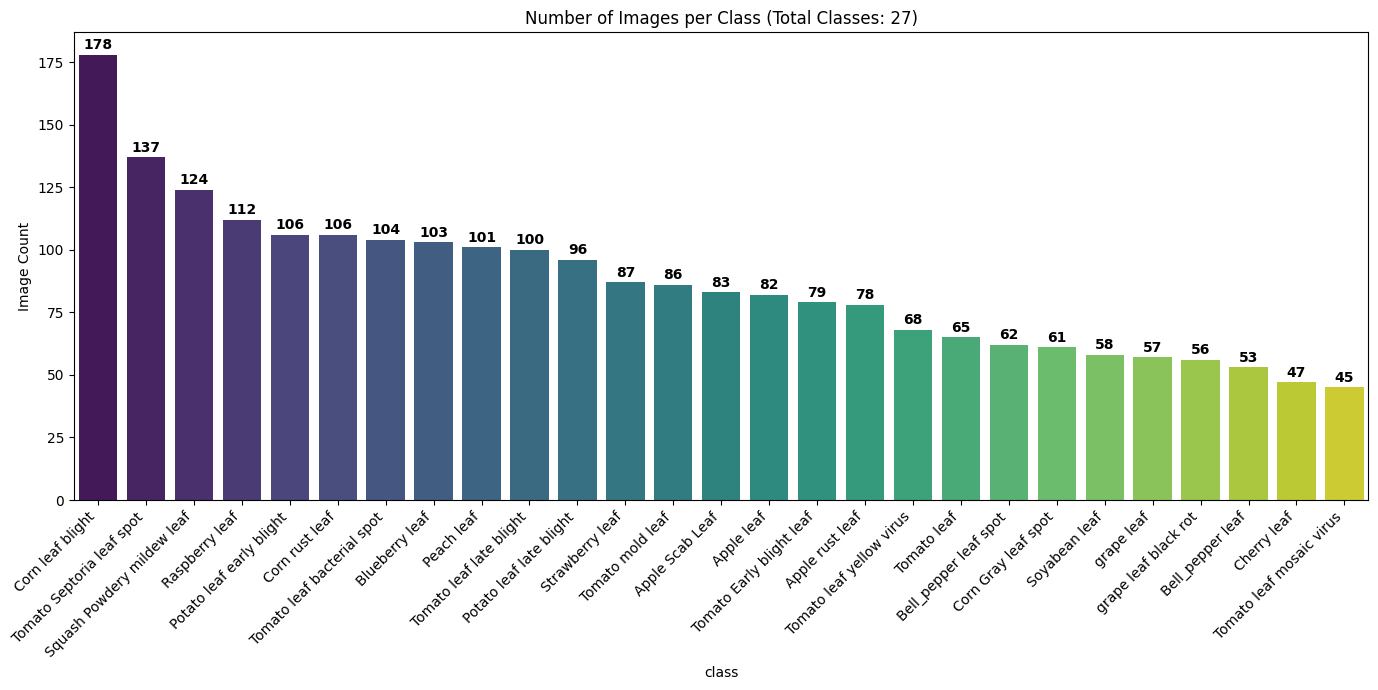

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate unique images per class
counts = train_annotation_df.groupby('class')['filename'].nunique().sort_values(ascending=False)

# 2. Get total number of unique classes
num_classes = train_annotation_df['class'].nunique()

# 3. Plot
plt.figure(figsize=(14, 7))
ax = sns.barplot(x=counts.index, y=counts.values, palette='viridis')

# 4. Add numbers on top of bars
for i, v in enumerate(counts.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontweight='bold')

# 5. Add the total class count to the title
plt.title(f"Number of Images per Class (Total Classes: {num_classes})")

# Rotate labels to 45 degrees
plt.xticks(rotation=45, ha='right')

plt.ylabel("Image Count")
plt.tight_layout()
plt.show()

/tmp/ipython-input-3698476265.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.index, y=counts.values, palette='viridis')


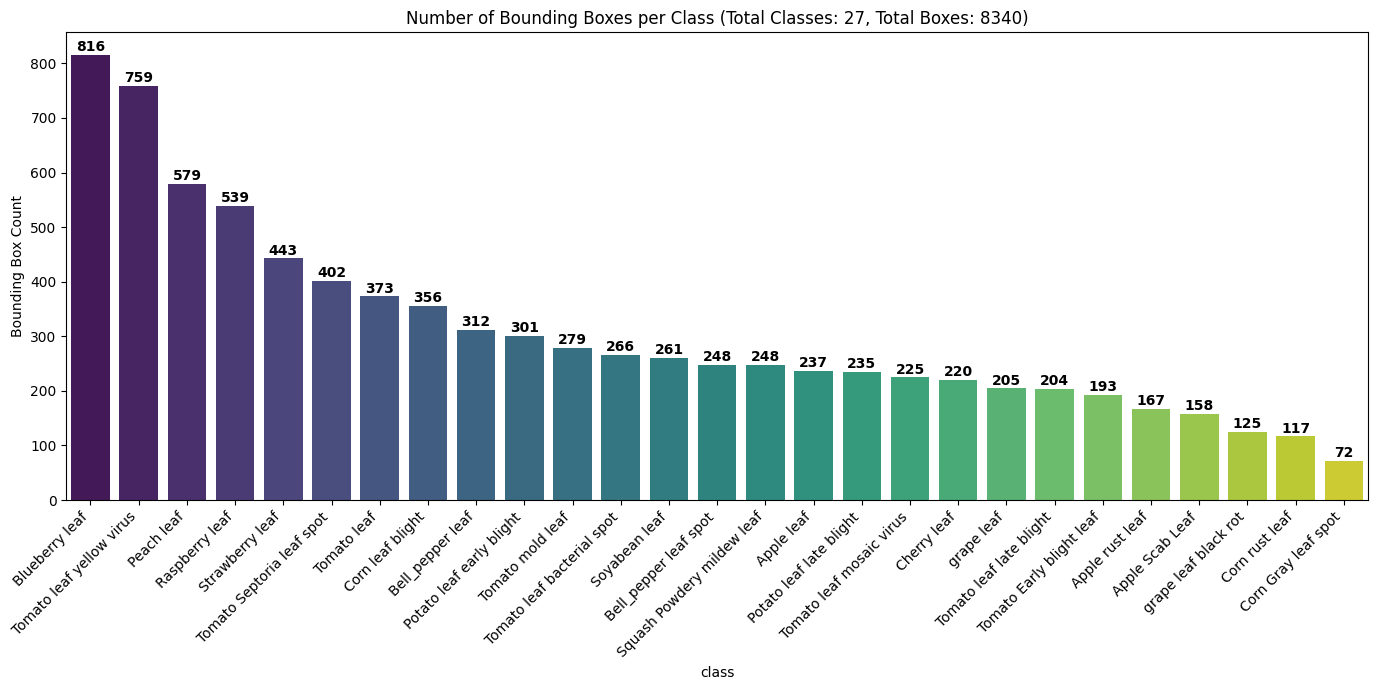

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Count rows per class
counts = train_annotation_df['class'].value_counts()

# 2. Get statistics
num_classes = train_annotation_df['class'].nunique()
total_bboxes = len(train_annotation_df)  # Total rows = Total bounding boxes

# 3. Plot
plt.figure(figsize=(14, 7))
ax = sns.barplot(x=counts.index, y=counts.values, palette='viridis')

# 4. Add numbers on top of bars
for i, v in enumerate(counts.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontweight='bold')

# 5. Add Total Classes and Total Boxes to the title
plt.title(f"Number of Bounding Boxes per Class (Total Classes: {num_classes}, Total Boxes: {total_bboxes})")

# Rotate labels to 45 degrees
plt.xticks(rotation=45, ha='right')

plt.ylabel("Bounding Box Count")
plt.tight_layout()
plt.show()

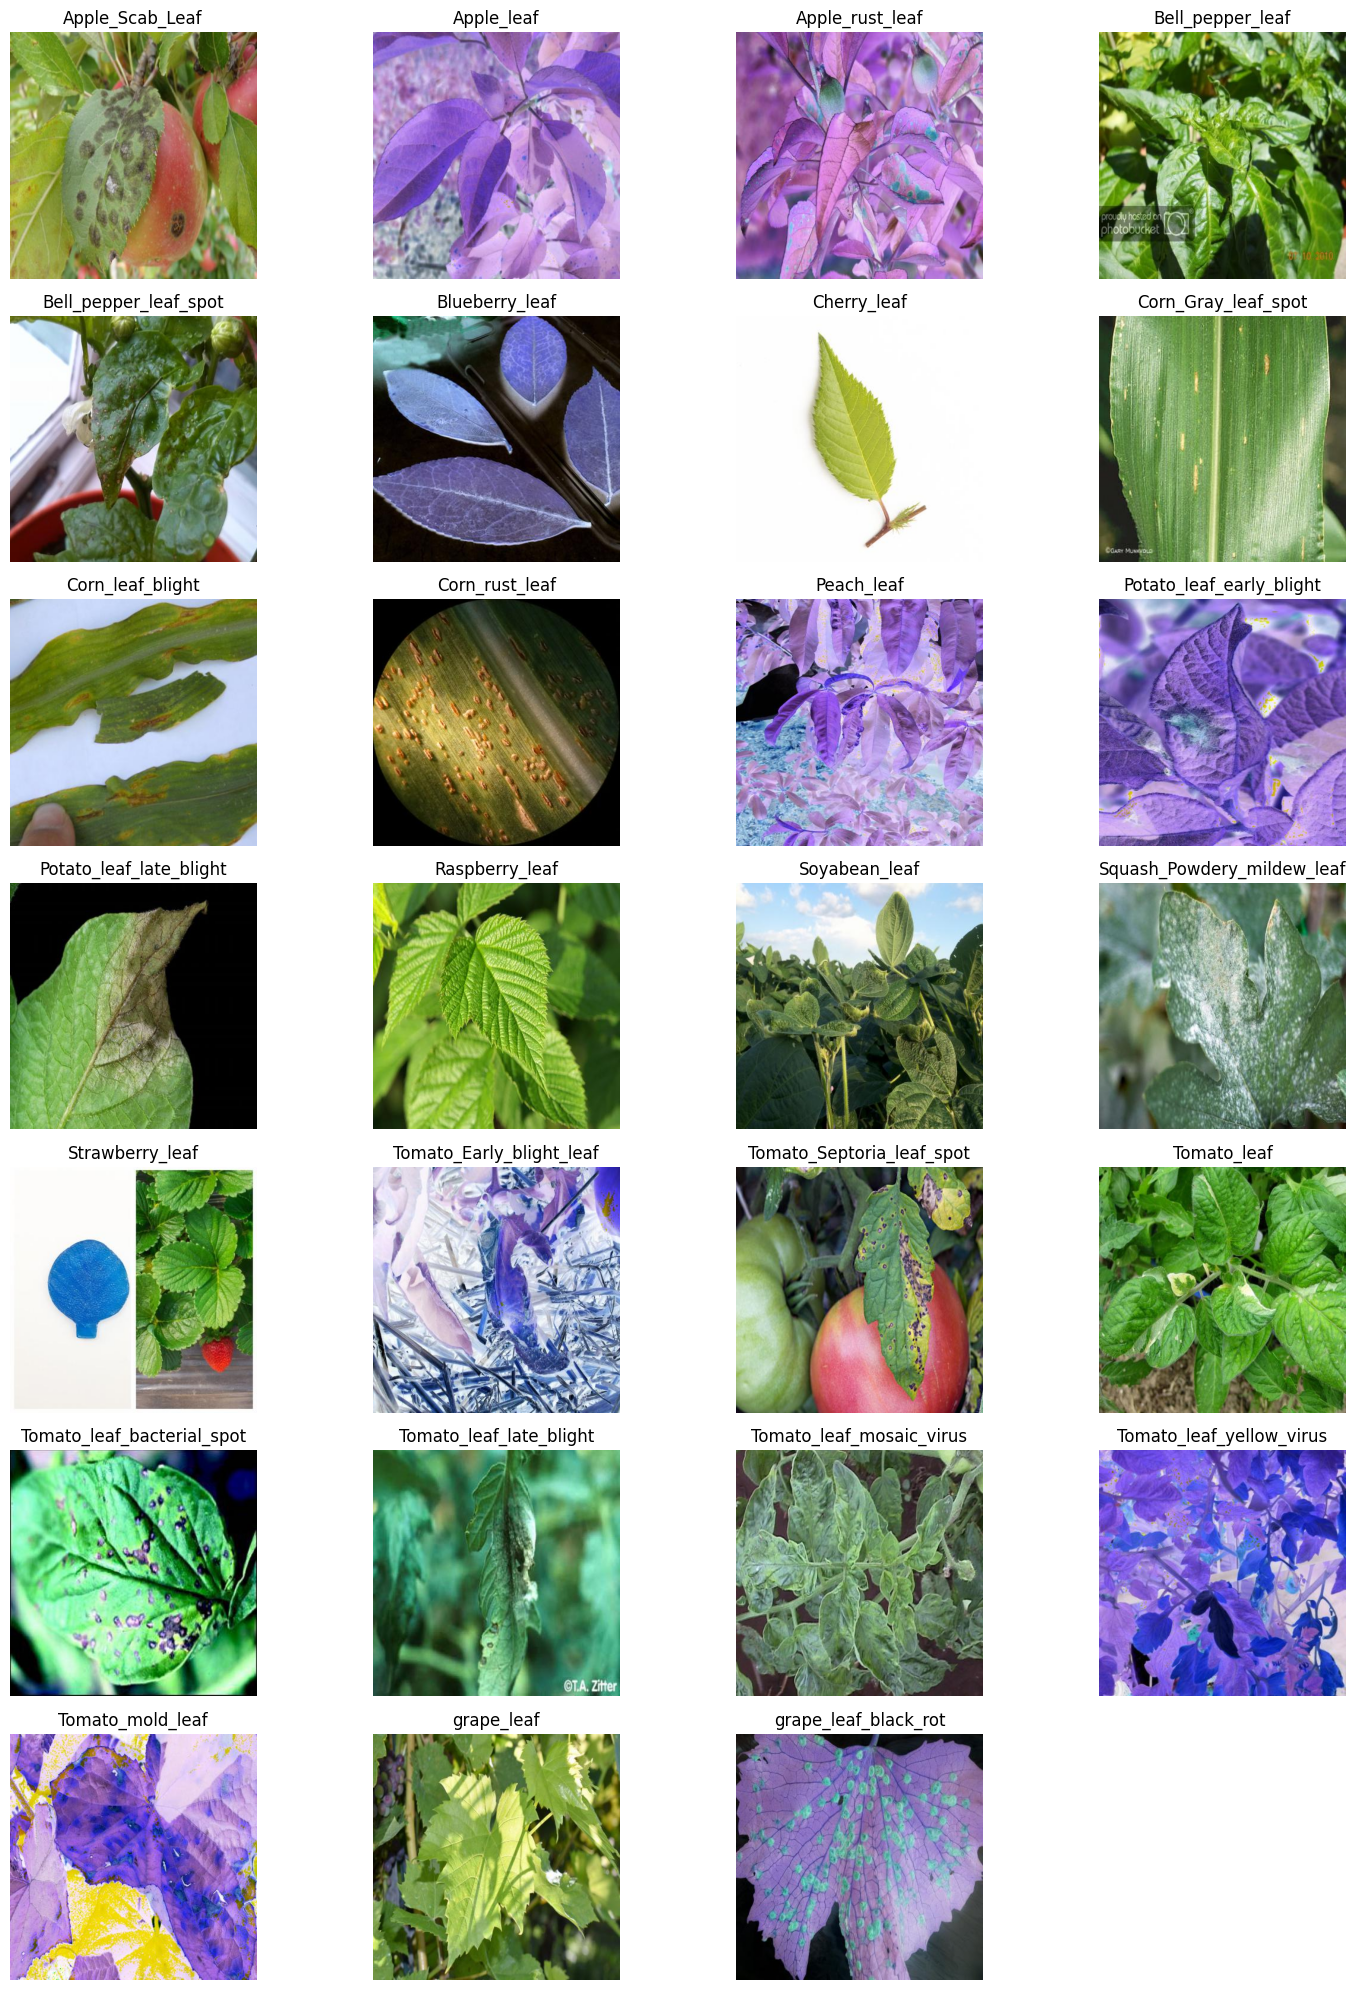

In [49]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Get list of directories (assuming all items in base_dir are directories)
class_dirs = sorted(os.listdir(train_images_separated))

plt.figure(figsize=(15, 20))

for i, class_name in enumerate(class_dirs):
    class_dir = os.path.join(train_images_separated, class_name)

    # Pick the first file directly (assuming the directory is not empty)
    first_image_file = sorted(os.listdir(class_dir))[0]  # Sort images alphabetically
    image_path = os.path.join(class_dir, first_image_file)

    # Load and plot directly
    img = mpimg.imread(image_path)

    plt.subplot(len(class_dirs) // 4 + 1, 4, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


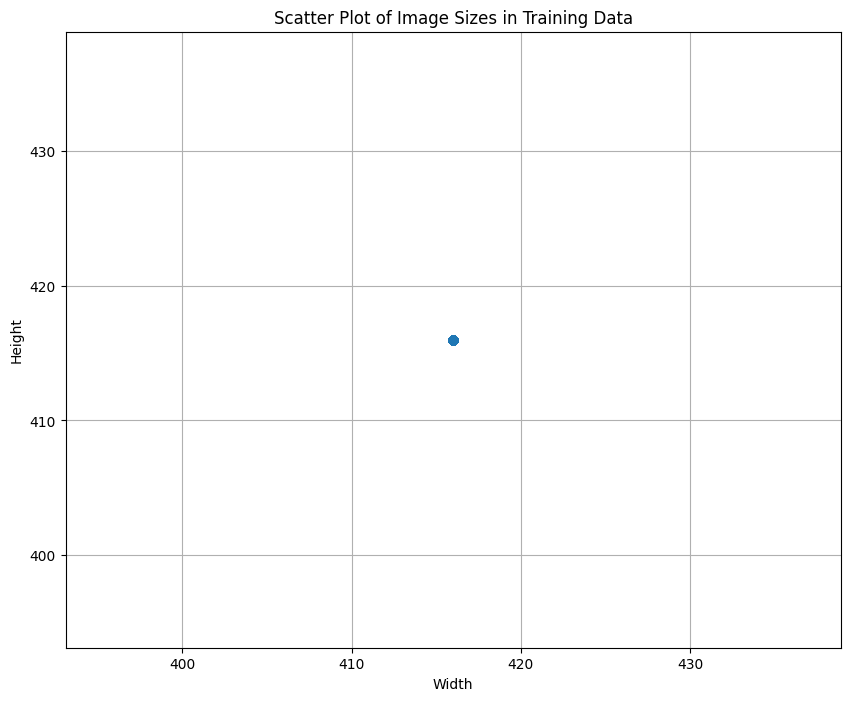

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

image_dir = "/content/train/images"

# 1. Get all sizes directly (assumes all files in folder are images)
image_sizes = [Image.open(os.path.join(image_dir, f)).size for f in os.listdir(image_dir)]

# 2. Extract widths and heights
widths = [s[0] for s in image_sizes]
heights = [s[1] for s in image_sizes]

# 3. Plot
plt.figure(figsize=(10, 8))
plt.scatter(widths, heights, alpha=0.5)
plt.title("Scatter Plot of Image Sizes in Training Data")
plt.xlabel("Width")
plt.ylabel("Height")
plt.grid(True)
plt.show()

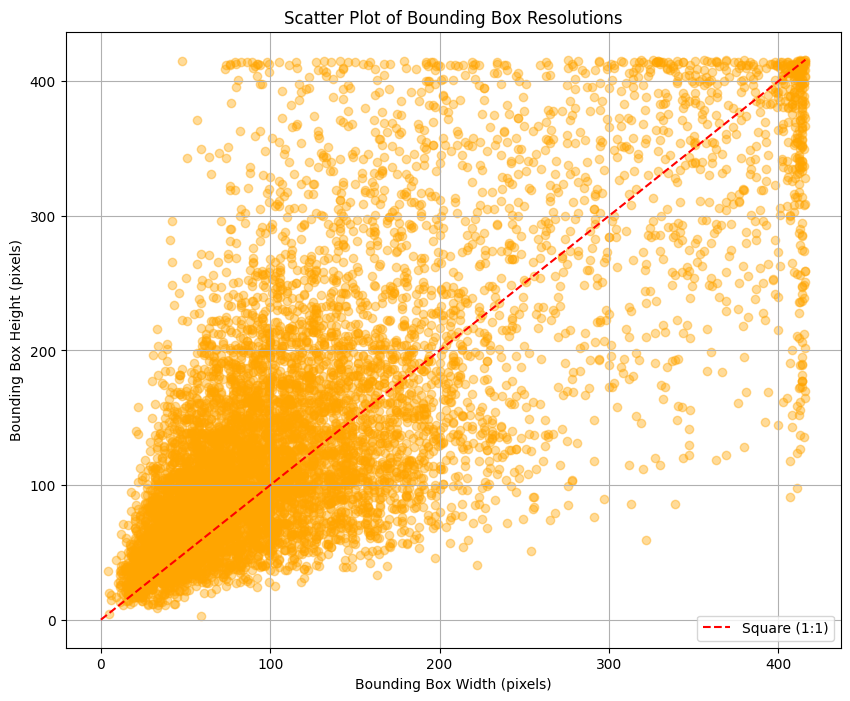

Min width:  4, Max width:  416
Min height: 3, Max height: 416


In [50]:
import matplotlib.pyplot as plt

# Compute bbox width and height
bbox_widths = (train_annotation_df["xmax"] - train_annotation_df["xmin"]).values
bbox_heights = (train_annotation_df["ymax"] - train_annotation_df["ymin"]).values

plt.figure(figsize=(10, 8))

# 1. Changed color to orange
plt.scatter(bbox_widths, bbox_heights, alpha=0.4, color='orange')

# 2. Add diagonal reference line (Square 1:1)
# Go from 0 to the maximum dimension found in the data
max_dim = max(bbox_widths.max(), bbox_heights.max())
plt.plot([0, max_dim], [0, max_dim], color='red', linestyle='--', label='Square (1:1)')

plt.title("Scatter Plot of Bounding Box Resolutions")
plt.xlabel("Bounding Box Width (pixels)")
plt.ylabel("Bounding Box Height (pixels)")
plt.legend()
plt.grid(True)
plt.show()

# Print stats
print(f"Min width:  {bbox_widths.min()}, Max width:  {bbox_widths.max()}")
print(f"Min height: {bbox_heights.min()}, Max height: {bbox_heights.max()}")

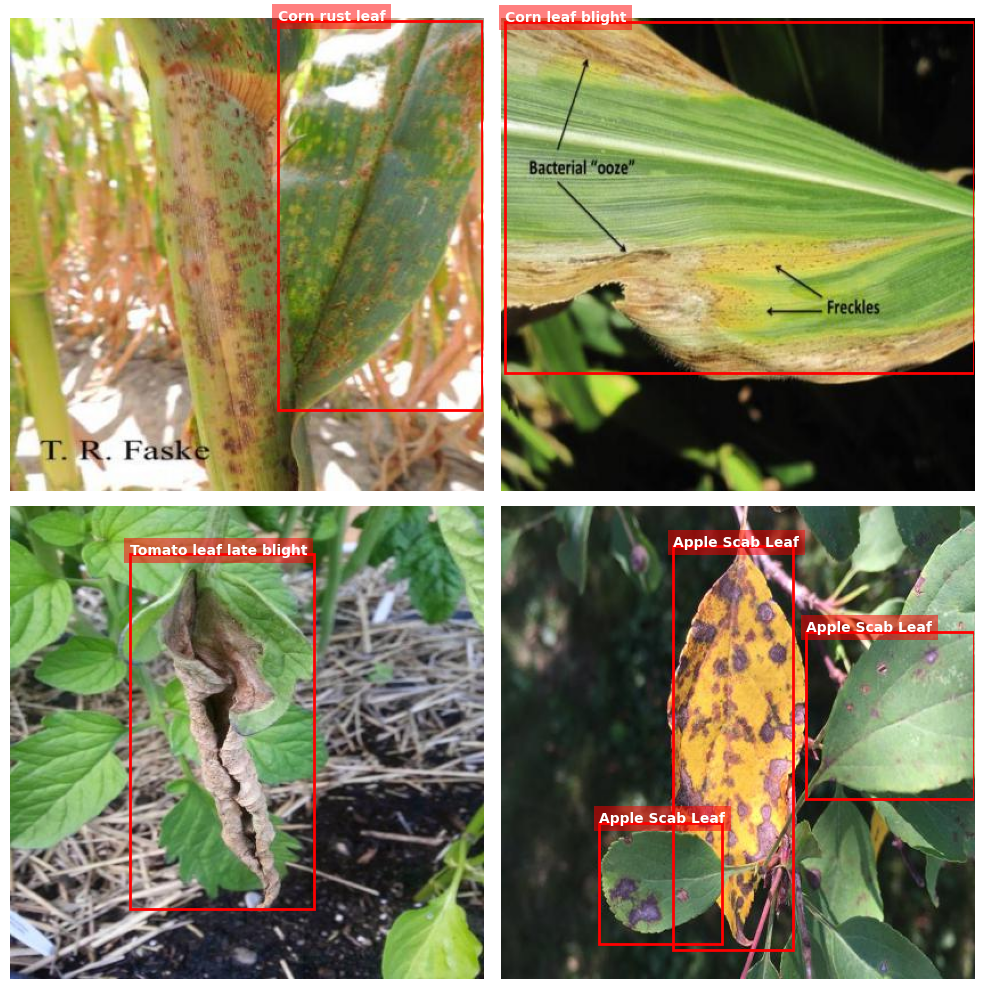

In [52]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# 1. Select the FIRST 4 unique images (Deterministic)
# unique() preserves order of appearance, so this always gives the same 4
samples = list(train_annotation_df['filename'].unique())[:4]


# 2. Setup grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# 3. Plot images, boxes, and labels
for i, filename in enumerate(samples):
    ax = axes[i//2, i%2]
    try:
        ax.imshow(Image.open(f"{train_images_new}/{filename}"))
    except FileNotFoundError:
        print(f"File not found: {filename}")
        continue

    # Add boxes and labels
    for _, row in train_annotation_df[train_annotation_df['filename'] == filename].iterrows():
        rect = patches.Rectangle((row['xmin'], row['ymin']), row['xmax']-row['xmin'], row['ymax']-row['ymin'],
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(row['xmin'], row['ymin'], row['class'], color='white', fontsize=10, weight='bold',
                bbox=dict(facecolor='red', alpha=0.5, edgecolor='none'))

    ax.axis('off')

plt.tight_layout()
plt.show()

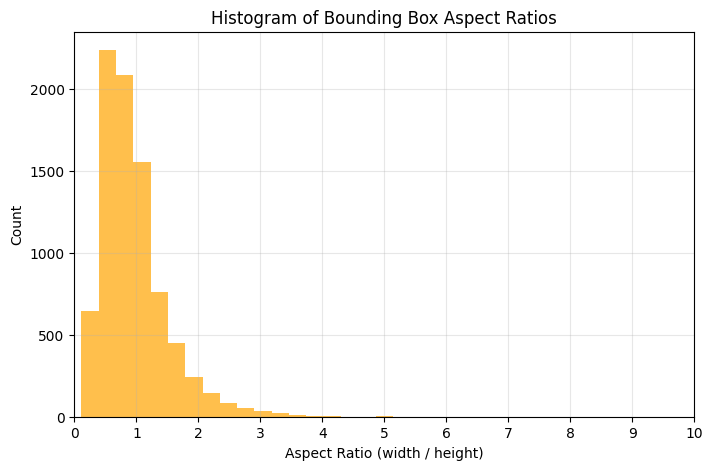

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Compute aspect ratios
widths = (train_annotation_df["xmax"] - train_annotation_df["xmin"]).values
heights = (train_annotation_df["ymax"] - train_annotation_df["ymin"]).values
aspect_ratios = widths / np.maximum(heights, 1e-6)  # Avoid divide-by-zero

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(aspect_ratios, bins=70, color='orange', alpha=0.7)
plt.title("Histogram of Bounding Box Aspect Ratios")
plt.xlabel("Aspect Ratio (width / height)")
plt.ylabel("Count")
plt.xlim(0, 10)  # Limit x-axis to a maximum of 10

# Set x-axis intervals to 1
plt.xticks(np.arange(0, 11, 1))

plt.grid(alpha=0.3)
plt.show()


/tmp/ipython-input-2307844740.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=classes, showfliers=False)


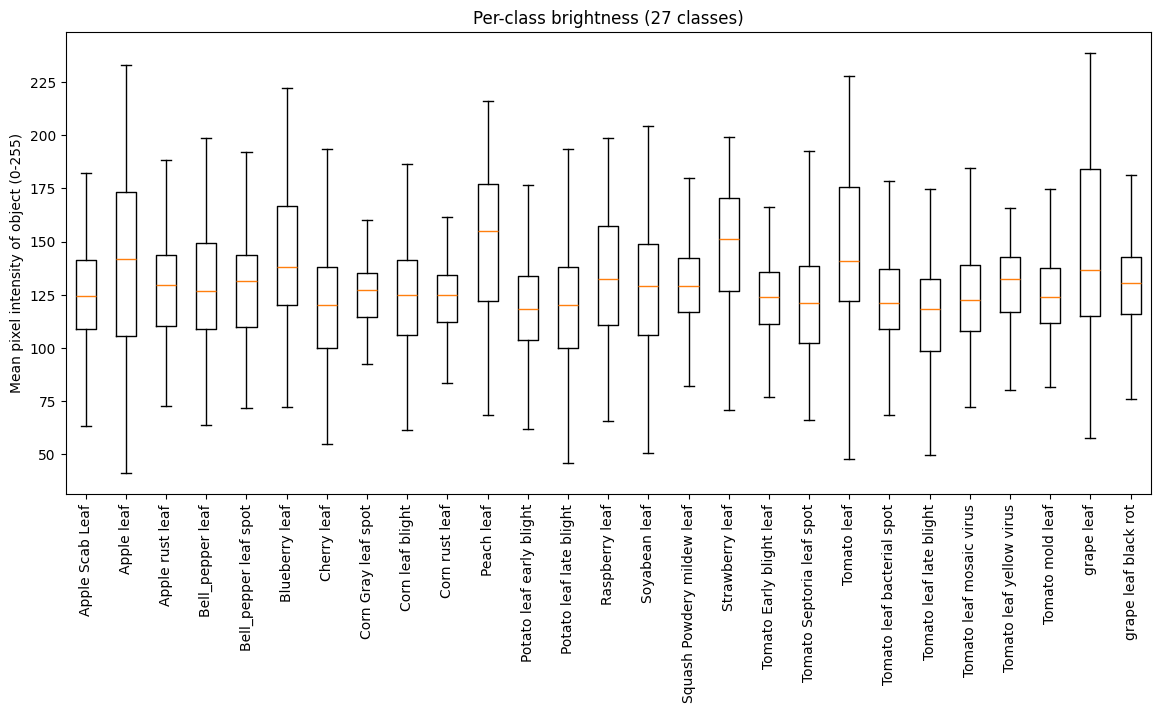

In [67]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Make sure train_annotation_df is already loaded (pandas DataFrame)
classes = sorted(train_annotation_df["class"].unique())

# dict: class_id -> list of mean intensities for its boxes
brightness_by_class = {c: [] for c in classes}

# to avoid doing MILLIONS of crops, we can limit samples per class
max_samples_per_class = 200

# cache images so we don't read same file many times
image_cache = {}

for idx, row in train_annotation_df.iterrows():
    cls = row["class"]
    # stop if we already collected enough samples for this class
    if len(brightness_by_class[cls]) >= max_samples_per_class:
        continue

    img_name = row["filename"]   # adjust column name if different
    img_path = os.path.join(train_images_new, img_name)

    if img_path not in image_cache:
        img = cv2.imread(img_path)
        if img is None:
            continue
        image_cache[img_path] = img
    else:
        img = image_cache[img_path]

    h, w = img.shape[:2]

    # get bbox (assume pixel coordinates)
    x_min = int(row["xmin"])
    y_min = int(row["ymin"])
    x_max = int(row["xmax"])
    y_max = int(row["ymax"])

    # clip to image bounds (important)
    x_min = max(0, min(x_min, w-1))
    x_max = max(0, min(x_max, w))
    y_min = max(0, min(y_min, h-1))
    y_max = max(0, min(y_max, h))

    if x_max <= x_min or y_max <= y_min:
        continue

    crop = img[y_min:y_max, x_min:x_max]

    # convert crop to grayscale and take mean intensity
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    mean_intensity = float(gray.mean())

    brightness_by_class[cls].append(mean_intensity)

# Prepare data for plotting
data = [brightness_by_class[c] for c in classes]

plt.figure(figsize=(14,6))
plt.boxplot(data, labels=classes, showfliers=False)
plt.xticks(rotation=90)
plt.ylabel("Mean pixel intensity of object (0-255)")
plt.title("Per-class brightness (27 classes)")
plt.show()


# **Data Preprocessing**

**Spliting train and validation data for 0.1 percentage**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path

df = train_annotation_df

# One row per image: pick a representative class per image (most frequent class)
per_image = (
    df.groupby('filename')['class']
      .agg(lambda s: s.mode().iat[0])  # if multiple modes, take the first
      .reset_index()
)

# Split image names into train/val (shuffles by default; set random_state for reproducibility)
train_names, val_names = train_test_split(
    per_image['filename'],
    test_size=0.1,         # 20% goes to validation
    shuffle=True,          # default is True; included here for clarity
    random_state=42,       # make the split repeatable
    stratify=per_image['class']  # keep class distribution balanced
)

# Filter the original CSV rows by image names → full per-image annotations
train_df = df[df['filename'].isin(train_names)]
val_df   = df[df['filename'].isin(val_names)]


SAVE_train = Path(train_images_old)
SAVE_train.mkdir(parents=True, exist_ok=True)

SAVE_val = Path(val_images_old)
SAVE_val.mkdir(parents=True, exist_ok=True)



# Save split CSVs
train_df.to_csv(SAVE_train / "train_annotations.csv", index=False)
val_df.to_csv(SAVE_val / "val_annotations.csv", index=False)

print(f"Saved {len(train_df)} rows to {SAVE_train / 'train_annotations.csv'}")
print(f"Saved {len(val_df)} rows to {SAVE_val / 'val_annotations.csv'}")

Saved 7418 rows to /content/train/train_annotations.csv
Saved 922 rows to /content/val/val_annotations.csv


**Moving splitted images to validation folder**

In [ ]:
import os
import shutil

# Define the base directory for the training images
base_dir = train_images_new

# Define the directory for the validation images
val_dir = val_images_new
os.makedirs(val_dir, exist_ok=True)

# Move validation images to the validation directory
moved_count = 0
for filename in val_df['filename'].unique():
    src_path = os.path.join(base_dir, filename)
    dest_path = os.path.join(val_dir, filename)
    if os.path.exists(src_path):
        shutil.move(src_path, dest_path)
        moved_count += 1
    else:
        print(f"Warning: File not found in training directory: {src_path}")

print(f"\nAttempted to move {len(val_df['filename'].unique())} unique validation images. Successfully moved {moved_count} images to {val_dir}.")


Attempted to move 232 unique validation images. Successfully moved 232 images to /content/val/images.


**Making function for converting CSV files to TXT files for YOLO**

In [ ]:
import pandas as pd
from pathlib import Path
from urllib.parse import unquote
import re

def convert_csv_to_yolo(CSV_PATH, OUT_DIR):
  # -------- Paths (edit these) --------
  CSV_PATH = CSV_PATH           # your CSV file
  OUT_DIR  = OUT_DIR # output folder for YOLO label .txt files

  # -------- Exact class order (IDs 0..26) --------
  CLASSES = [
      'Apple Scab Leaf','Apple leaf','Apple rust leaf','Bell_pepper leaf','Bell_pepper leaf spot',
      'Blueberry leaf','Cherry leaf','Corn Gray leaf spot','Corn leaf blight','Corn rust leaf',
      'Peach leaf','Potato leaf early blight','Potato leaf late blight','Raspberry leaf','Soyabean leaf',
      'Squash Powdery mildew leaf','Strawberry leaf','Tomato Early blight leaf','Tomato Septoria leaf spot',
      'Tomato leaf','Tomato leaf bacterial spot','Tomato leaf late blight','Tomato leaf mosaic virus',
      'Tomato leaf yellow virus','Tomato mold leaf','grape leaf','grape leaf black rot'
  ]
  assert len(CLASSES) == 27, "CLASSES must contain exactly 27 names."

  # Normalize class names for robust matching (spaces/underscores/case-insensitive)
  def norm(s: str) -> str:
      s = unquote(str(s)).strip()
      s = s.replace("_", " ")
      s = re.sub(r"\s+", " ", s)
      return s.lower()

  name2id = {norm(name): i for i, name in enumerate(CLASSES)}

  # -------- Read CSV --------
  df = pd.read_csv(CSV_PATH)
  df.columns = [str(c).strip().lower() for c in df.columns]

  required = ["filename","width","height","class","xmin","ymin","xmax","ymax"]
  missing = [c for c in required if c not in df.columns]
  if missing:
      raise ValueError(f"Missing required CSV columns: {missing}")

  # Keep only the filename (drop folders) and build the stem (basename without extension)
  df["__file"] = df["filename"].map(lambda x: Path(unquote(str(x))).name)
  df["__stem"] = df["__file"].map(lambda x: Path(x).stem)

  # Ensure every class in CSV exists in your CLASSES list
  unknown = sorted(set(norm(x) for x in df["class"]) - set(name2id.keys()))
  if unknown:
      raise ValueError(
          "Some CSV classes are not in your CLASSES list (so IDs cannot match your order):\n"
          + "\n".join(unknown)
      )

  # Convert one row to a YOLO line: "<class_id> <cx> <cy> <w> <h>" (all normalized to [0,1])
  def row_to_line(r):
      W, H = float(r["width"]), float(r["height"])
      xmin, ymin, xmax, ymax = float(r["xmin"]), float(r["ymin"]), float(r["xmax"]), float(r["ymax"])

      # Standard YOLO conversion from XYXY (top-left / bottom-right in pixels)
      cx = ((xmin + xmax) / 2.0) / W
      cy = ((ymin + ymax) / 2.0) / H
      w  = (xmax - xmin) / W
      h  = (ymax - ymin) / H

      # Clamp to [0,1] just in case
      clip = lambda v: max(0.0, min(1.0, float(v)))
      cx, cy, w, h = map(clip, (cx, cy, w, h))

      cls_id = name2id[norm(r["class"])]
      return f"{cls_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}"

  # -------- Write one .txt per image (same basename) --------
  out = Path(OUT_DIR)
  out.mkdir(parents=True, exist_ok=True)

  files_written = 0
  boxes_total = 0
  for stem, g in df.groupby("__stem"):
      lines = [row_to_line(r) for _, r in g.iterrows()]
      (out / f"{stem}.txt").write_text("\n".join(lines), encoding="utf-8")
      files_written += 1
      boxes_total += len(lines)

  '''# Optional: save the classes list (ID order) for reference
  (out / "classes.txt").write_text("\n".join(CLASSES), encoding="utf-8")'''

  print(f"✅ Done: wrote {files_written} label files with {boxes_total} boxes into: {out}")
  print("Class ID mapping (id → name):")
  for i, name in enumerate(CLASSES):
      print(f"{i:2d}: {name}")


**Converting train csv to txt**

In [ ]:
convert_csv_to_yolo(train_splitted_csv, train_yolo_labels)

✅ Done: wrote 2086 label files with 7418 boxes into: /content/train/labels
Class ID mapping (id → name):
 0: Apple Scab Leaf
 1: Apple leaf
 2: Apple rust leaf
 3: Bell_pepper leaf
 4: Bell_pepper leaf spot
 5: Blueberry leaf
 6: Cherry leaf
 7: Corn Gray leaf spot
 8: Corn leaf blight
 9: Corn rust leaf
10: Peach leaf
11: Potato leaf early blight
12: Potato leaf late blight
13: Raspberry leaf
14: Soyabean leaf
15: Squash Powdery mildew leaf
16: Strawberry leaf
17: Tomato Early blight leaf
18: Tomato Septoria leaf spot
19: Tomato leaf
20: Tomato leaf bacterial spot
21: Tomato leaf late blight
22: Tomato leaf mosaic virus
23: Tomato leaf yellow virus
24: Tomato mold leaf
25: grape leaf
26: grape leaf black rot


**Converting Validation csv to txt**

In [ ]:
convert_csv_to_yolo(val_annotation_clean, val_yolo_labels)

✅ Done: wrote 232 label files with 922 boxes into: /content/val/labels
Class ID mapping (id → name):
 0: Apple Scab Leaf
 1: Apple leaf
 2: Apple rust leaf
 3: Bell_pepper leaf
 4: Bell_pepper leaf spot
 5: Blueberry leaf
 6: Cherry leaf
 7: Corn Gray leaf spot
 8: Corn leaf blight
 9: Corn rust leaf
10: Peach leaf
11: Potato leaf early blight
12: Potato leaf late blight
13: Raspberry leaf
14: Soyabean leaf
15: Squash Powdery mildew leaf
16: Strawberry leaf
17: Tomato Early blight leaf
18: Tomato Septoria leaf spot
19: Tomato leaf
20: Tomato leaf bacterial spot
21: Tomato leaf late blight
22: Tomato leaf mosaic virus
23: Tomato leaf yellow virus
24: Tomato mold leaf
25: grape leaf
26: grape leaf black rot


**Converting test csv to txt**

In [ ]:
convert_csv_to_yolo(test_annotation_clean, test_yolo_labels)

✅ Done: wrote 238 label files with 454 boxes into: /content/test/labels
Class ID mapping (id → name):
 0: Apple Scab Leaf
 1: Apple leaf
 2: Apple rust leaf
 3: Bell_pepper leaf
 4: Bell_pepper leaf spot
 5: Blueberry leaf
 6: Cherry leaf
 7: Corn Gray leaf spot
 8: Corn leaf blight
 9: Corn rust leaf
10: Peach leaf
11: Potato leaf early blight
12: Potato leaf late blight
13: Raspberry leaf
14: Soyabean leaf
15: Squash Powdery mildew leaf
16: Strawberry leaf
17: Tomato Early blight leaf
18: Tomato Septoria leaf spot
19: Tomato leaf
20: Tomato leaf bacterial spot
21: Tomato leaf late blight
22: Tomato leaf mosaic virus
23: Tomato leaf yellow virus
24: Tomato mold leaf
25: grape leaf
26: grape leaf black rot


**Making data.yaml for YOLO**

In [ ]:
import yaml

# Define the paths to your training and validation data
train_img_dir = train_images_new
#train_label_dir = '/content/train/labels'
val_img_dir = val_images_new
#val_label_dir = '/content/validation/labels'
test_img_dir = test_images_new
#test_label_dir = '/content/test/labels'


# Define the class names in the order they appear in your labels
classes = [
    'Apple Scab Leaf','Apple leaf','Apple rust leaf','Bell_pepper leaf','Bell_pepper leaf spot',
    'Blueberry leaf','Cherry leaf','Corn Gray leaf spot','Corn leaf blight','Corn rust leaf',
    'Peach leaf','Potato leaf early blight','Potato leaf late blight','Raspberry leaf','Soyabean leaf',
    'Squash Powdery mildew leaf','Strawberry leaf','Tomato Early blight leaf','Tomato Septoria leaf spot',
    'Tomato leaf','Tomato leaf bacterial spot','Tomato leaf late blight','Tomato leaf mosaic virus',
    'Tomato leaf yellow virus','Tomato mold leaf','grape leaf','grape leaf black rot'
]



# Create the data dictionary
data = {
    'train': train_img_dir,
    'val': val_img_dir,
    'test': test_img_dir,
    'nc': len(classes),
    'names': classes,
}

# Define the path to save the data.yaml file
data_yaml_path = yaml_path

# Write the data dictionary to the data.yaml file
with open(data_yaml_path, 'w') as f:
    yaml.dump(data, f)

print(f"data.yaml file created at: {data_yaml_path}")

data.yaml file created at: /content/data.yaml


# **Modeling**

In [ ]:
!pip install "ultralytics==8.2.28"
# or another 8.2.x version


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 47.1 MB/s eta 0:00:00


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.2 MB/s eta 0:00:00


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA available: True
GPU name: Tesla T4


In [ ]:
!pip uninstall -y ultralytics torch torchvision torchaudio

!pip install "torch==2.3.1" "torchvision==0.18.1" "torchaudio==2.3.1"
!pip install "ultralytics==8.2.0"


Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 128.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 119.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 135.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLO12n model
model = YOLO("yolov8n.pt")

100%|██████████| 6.23M/6.23M [00:00<00:00, 94.0MB/s]


In [ ]:
model.info()

YOLOv8n summary: 225 layers, 3157200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

In [ ]:
import os
os.environ["WANDB_MODE"] = "disabled"


In [ ]:
model.train(
    data=yaml_path,
    epochs=100,
    imgsz=416,
    batch=32,         # auto
    optimizer='AdamW',
    device=0, # or 'SGD', 'Adam', etc.
    #album=transform # Pass the albumentations transform
    augment=True,          # not enough by itself, but keep False
    #mosaic=0.0,
    #mixup=0.0,
    #cutmix=0.0,             # (mostly cls/seg)
    #copy_paste=0.0,         # (seg only)

    #hsv_h=0.0, hsv_s=0.0, hsv_v=0.0,
    #bgr=0.0,                # channel swap prob
    #degrees=0.0, translate=0.0, scale=0.0, shear=0.0,
    #perspective=0.0,
    #flipud=0.0, fliplr=0.0
)

New https://pypi.org/project/ultralytics/8.3.228 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.0 🚀 Python-3.12.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fals

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:


Abort: 

In [ ]:
model.train(
    data=yaml_path,
    epochs=100,
    imgsz=416,
    batch=32,         # auto
    optimizer='AdamW',
    device=0, # or 'SGD', 'Adam', etc.
    #album=transform # Pass the albumentations transform
    augment=True,          # not enough by itself, but keep False
    #mosaic=0.0,
    #mixup=0.0,
    #cutmix=0.0,             # (mostly cls/seg)
    #copy_paste=0.0,         # (seg only)

    #hsv_h=0.0, hsv_s=0.0, hsv_v=0.0,
    #bgr=0.0,                # channel swap prob
    #degrees=0.0, translate=0.0, scale=0.0, shear=0.0,
    #perspective=0.0,
    #flipud=0.0, fliplr=0.0
)

Ultralytics 8.3.192 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profi

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ca9f2325a00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0

In [ ]:
args = model.trainer.args
for k in [
    'augment','mosaic','mixup','copy_paste','cutmix',
    'degrees','translate','scale','shear','perspective',
    'flipud','fliplr','hsv_h','hsv_s','hsv_v','bgr'
]:
    print(f"{k:12} =", getattr(args, k, None))


augment      = True
mosaic       = 1.0
mixup        = 0.0
copy_paste   = 0.0
cutmix       = 0.0
degrees      = 0.0
translate    = 0.1
scale        = 0.5
shear        = 0.0
perspective  = 0.0
flipud       = 0.0
fliplr       = 0.5
hsv_h        = 0.015
hsv_s        = 0.7
hsv_v        = 0.4
bgr          = 0.0


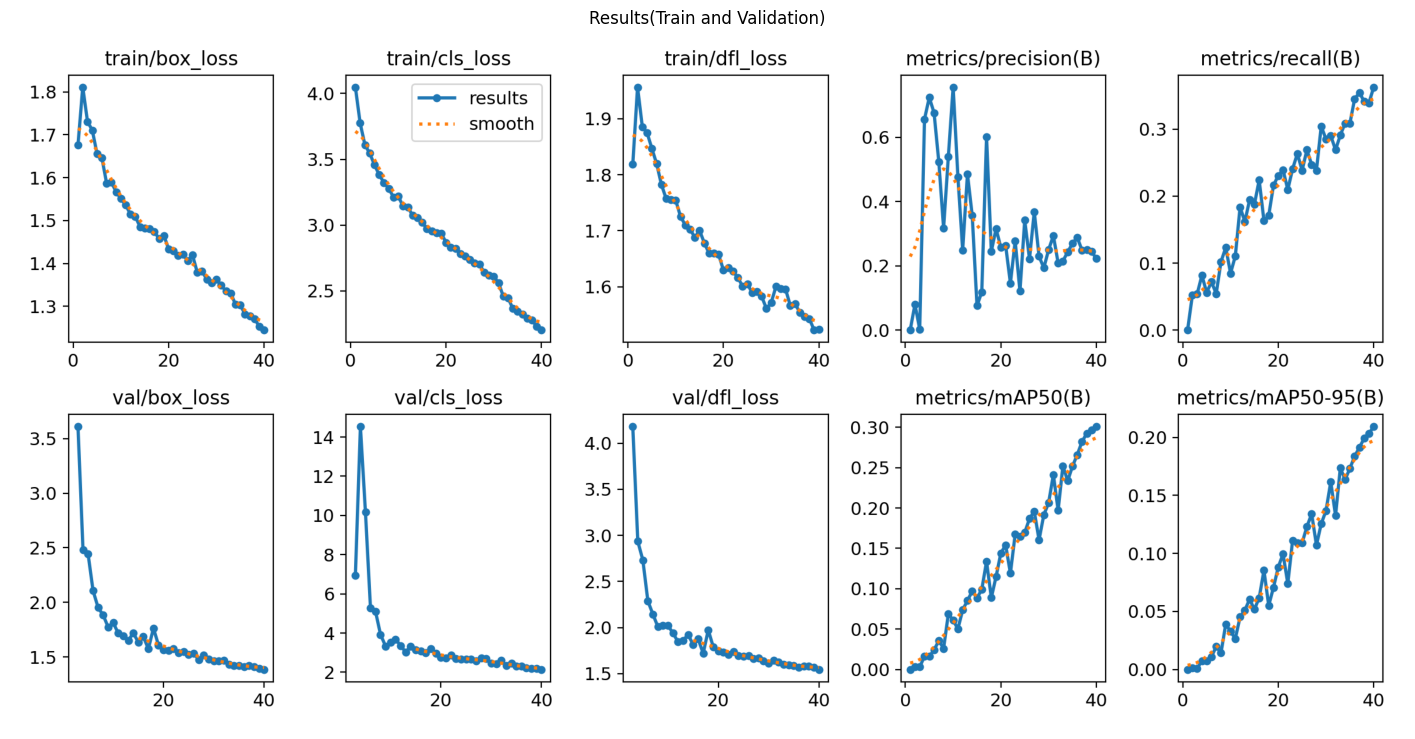

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = "/content/runs/detect/train/results.png"  # your file
img = Image.open(img_path)

plt.figure(figsize=(18, 18))
plt.imshow(img)
plt.axis("off")
plt.title("Results(Train and Validation)")
plt.show()

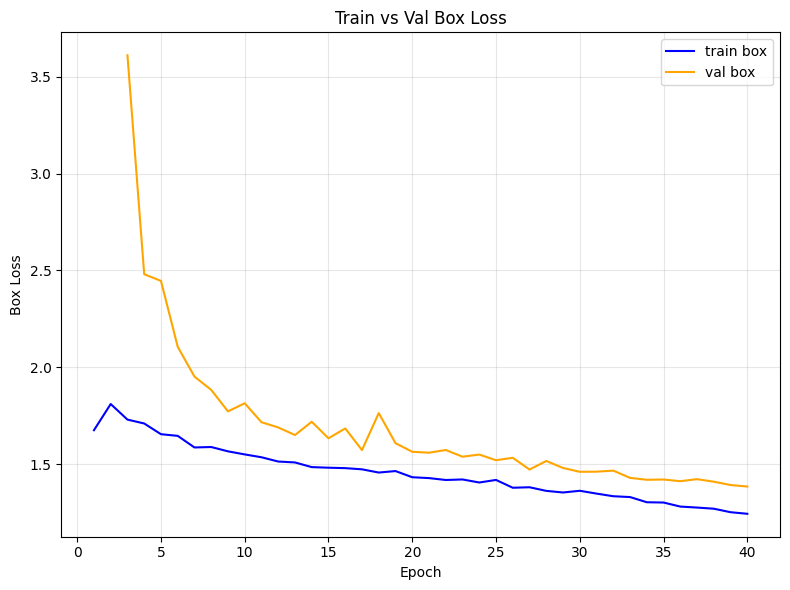

Saved: /content/runs/detect/train/train_vs_val_box_loss.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# CHANGE THIS to your run dir
RUN = Path("/content/runs/detect/train")

# Read the results from the CSV file
df = pd.read_csv(RUN / "results.csv")
x = df["epoch"] if "epoch" in df.columns else range(len(df))

# Create the plot for Train vs Val Box Loss
plt.figure(figsize=(8, 6))

# Plot train and val box loss
plt.plot(x, df["train/box_loss"], label="train box", color='blue')
plt.plot(x, df["val/box_loss"], label="val box", color='orange')

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("Box Loss")
plt.title("Train vs Val Box Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# Save the image to your results folder
out_path = RUN / "train_vs_val_box_loss.png"
plt.tight_layout()
plt.savefig(out_path, dpi=200)

# Display the plot
plt.show()

print("Saved:", out_path)


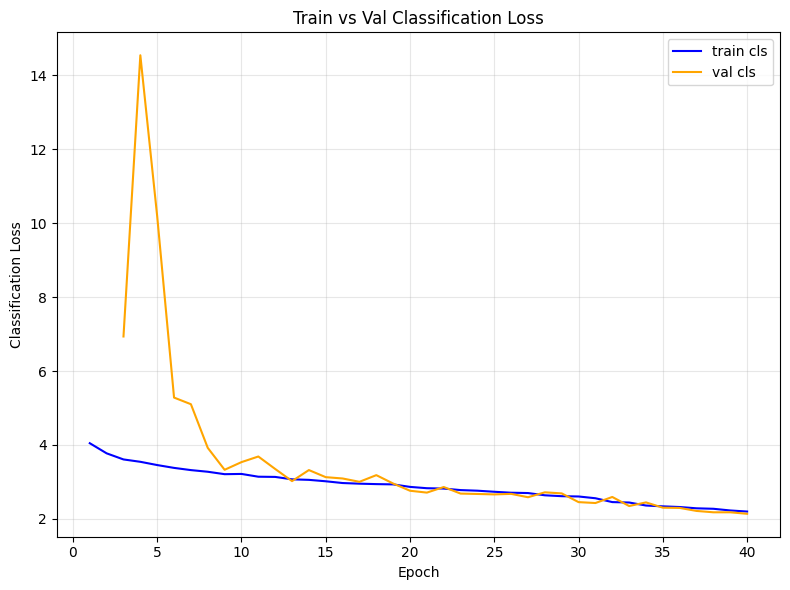

Saved: /content/runs/detect/train/train_vs_val_cls_loss.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# CHANGE THIS to your run dir
RUN = Path("/content/runs/detect/train/")

# Read the results from the CSV file
df = pd.read_csv(RUN / "results.csv")
x = df["epoch"] if "epoch" in df.columns else range(len(df))

# Create the plot for Train vs Val Classification Loss
plt.figure(figsize=(8, 6))

# Plot train and val classification loss
plt.plot(x, df["train/cls_loss"], label="train cls", color='blue')
plt.plot(x, df["val/cls_loss"], label="val cls", color='orange')

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("Classification Loss")
plt.title("Train vs Val Classification Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# Save the image to your results folder
out_path = RUN / "train_vs_val_cls_loss.png"
plt.tight_layout()
plt.savefig(out_path, dpi=200)

# Display the plot
plt.show()

print("Saved:", out_path)


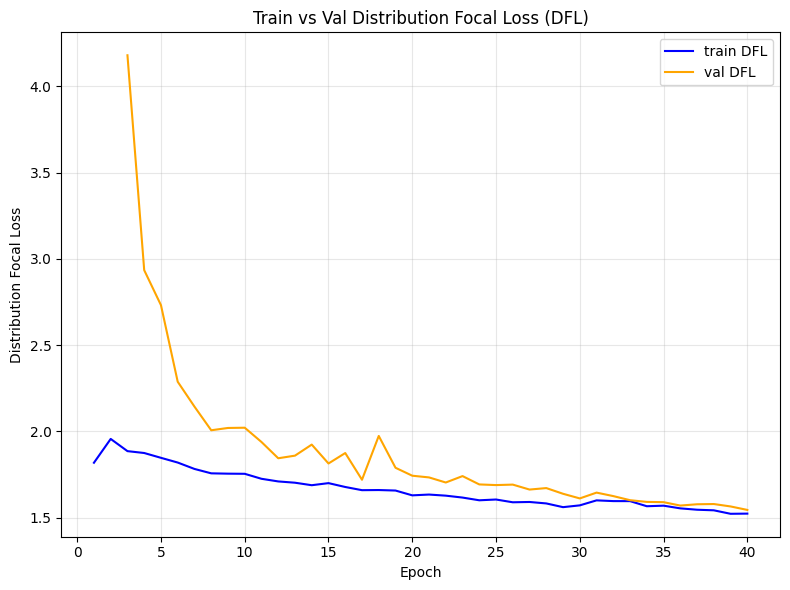

Saved: /content/runs/detect/train/train_vs_val_dfl_loss.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# CHANGE THIS to your run dir
RUN = Path("/content/runs/detect/train")

# Read the results from the CSV file
df = pd.read_csv(RUN / "results.csv")
x = df["epoch"] if "epoch" in df.columns else range(len(df))

# Create the plot for Train vs Val DFL Loss (Distribution Focal Loss)
plt.figure(figsize=(8, 6))

# Plot train and val DFL loss
plt.plot(x, df["train/dfl_loss"], label="train DFL", color='blue')
plt.plot(x, df["val/dfl_loss"], label="val DFL", color='orange')

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("Distribution Focal Loss")
plt.title("Train vs Val Distribution Focal Loss (DFL)")
plt.legend()
plt.grid(True, alpha=0.3)

# Save the image to your results folder
out_path = RUN / "train_vs_val_dfl_loss.png"
plt.tight_layout()
plt.savefig(out_path, dpi=200)

# Display the plot
plt.show()

print("Saved:", out_path)


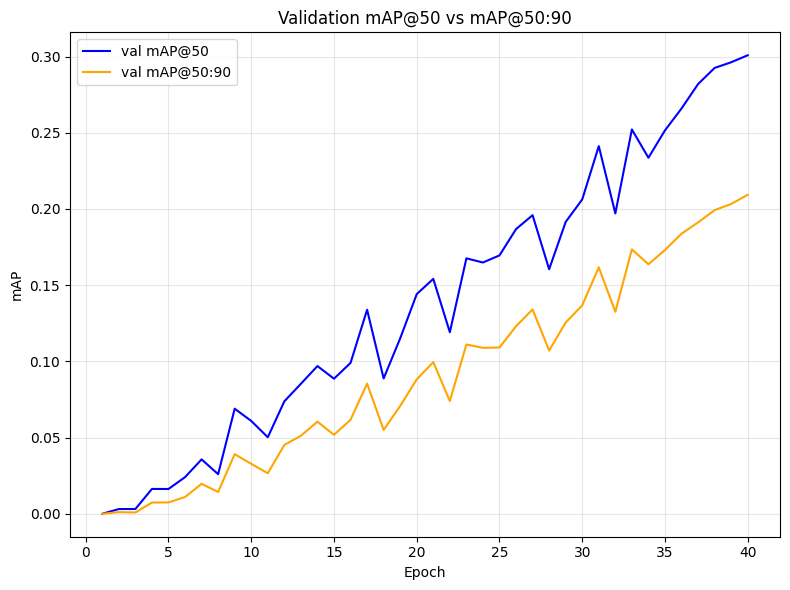

Saved: /content/runs/detect/train/val_mAP50_vs_mAP50_95.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# CHANGE THIS to your run dir
RUN = Path("/content/runs/detect/train")

# Read the results from the CSV file
df = pd.read_csv(RUN / "results.csv")
x = df["epoch"] if "epoch" in df.columns else range(len(df))

# Create the plot for Val mAP@50 and mAP@50:90
plt.figure(figsize=(8, 6))

# Plot val mAP@50 and val mAP@50:90 (use correct columns for val mAP)
plt.plot(x, df['metrics/mAP50(B)'], label="val mAP@50", color='blue')  # Validation mAP@50
plt.plot(x, df['metrics/mAP50-95(B)'], label="val mAP@50:90", color='orange')  # Validation mAP@50:95

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("Validation mAP@50 vs mAP@50:90")
plt.legend()
plt.grid(True, alpha=0.3)

# Save the image to your results folder
out_path = RUN / "val_mAP50_vs_mAP50_95.png"
plt.tight_layout()
plt.savefig(out_path, dpi=200)

# Display the plot
plt.show()

print("Saved:", out_path)


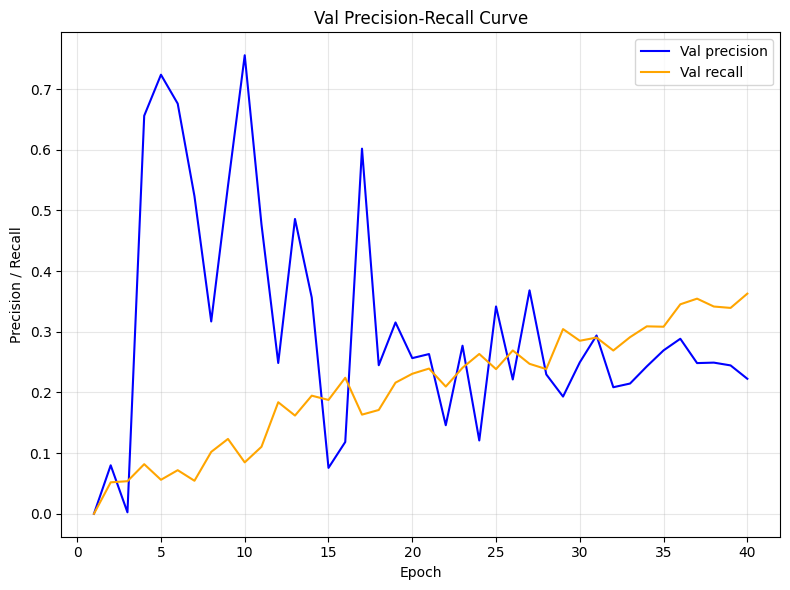

Saved: /content/runs/detect/train/train_vs_val_pr_curve.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# CHANGE THIS to your run dir
RUN = Path("/content/runs/detect/train")

# Read the results from the CSV file
df = pd.read_csv(RUN / "results.csv")
x = df["epoch"] if "epoch" in df.columns else range(len(df))

# Create the plot for Train Precision-Recall Curve
plt.figure(figsize=(8, 6))

# Plot train PR (Precision-Recall) curve
plt.plot(x, df["metrics/precision(B)"], label="Val precision", color='blue')
plt.plot(x, df["metrics/recall(B)"], label="Val recall", color='orange')

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("Precision / Recall")
plt.title("Val Precision-Recall Curve")
plt.legend()
plt.grid(True, alpha=0.3)

# Save the image to your results folder
out_path = RUN / "train_vs_val_pr_curve.png"
plt.tight_layout()
plt.savefig(out_path, dpi=200)

# Display the plot
plt.show()

print("Saved:", out_path)


In [ ]:
from ultralytics import YOLO

DATA = "/content/data.yaml"                 # must contain a `test:` entry
WEIGHTS = "runs/detect/train/weights/best.pt"

model = YOLO(WEIGHTS)

# Evaluate on TEST ONLY (requires test labels)
metrics = model.val(
    data=DATA,
    split='test',        # <-- key line
    imgsz=640,
    conf=0.25,
    iou=0.50,
    plots=True           # saves confusion_matrix.png and other plots
)
print(metrics)  # mAP, precision/recall, etc.


Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,561,993 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 872.4±198.9 MB/s, size: 25.8 KB)
val: Scanning /content/test/labels... 238 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 238/238 2061.6it/s 0.1s
val: New cache created: /content/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 3.5it/s 4.3s
                   all        238        454      0.253      0.314      0.295       0.24
       Apple Scab Leaf         10         13       0.75      0.231        0.5      0.421
            Apple leaf          9         10      0.189        0.7      0.419      0.316
       Apple rust leaf         10         11          0          0          0          0
      Bell_pepper leaf          8         11          0          0          0          0
 Bell_pep

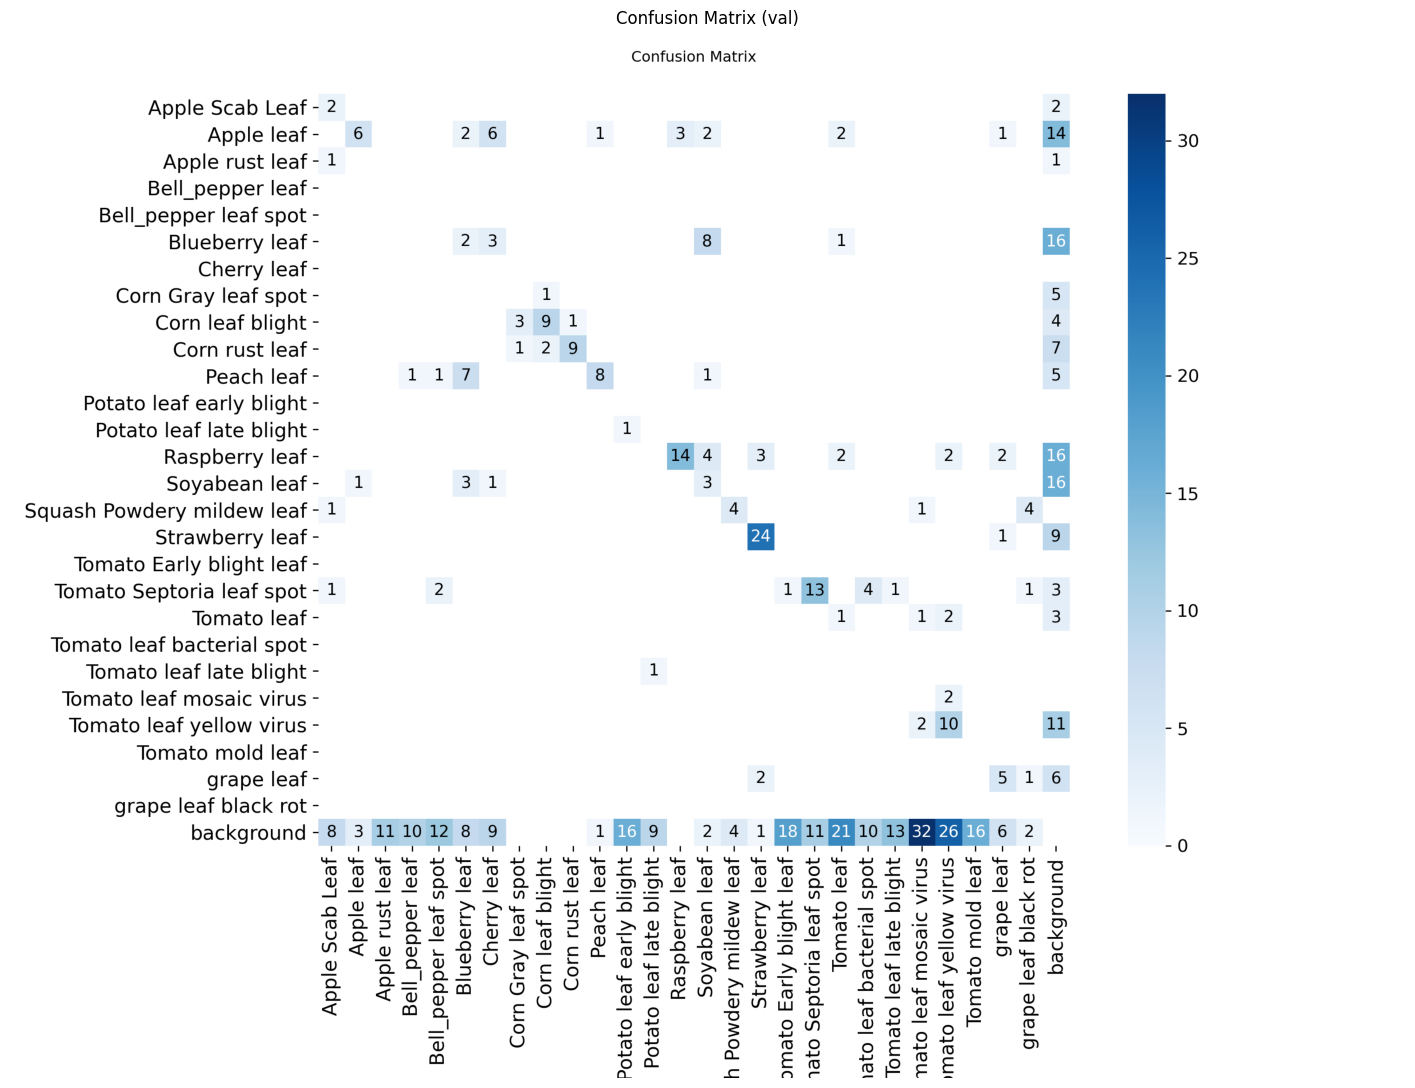

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = "/content/runs/detect/val/confusion_matrix.png"  # your file
img = Image.open(img_path)

plt.figure(figsize=(18, 18))
plt.imshow(img)
plt.axis("off")
plt.title("Confusion Matrix (val)")
plt.show()
